In [1]:
# Date: Jan 11

# Uses effort advantage

import numpy as np
import sys, os
import pickle
import importlib

# Import custom scripts

import context
from context import rlcoop, DATA_PATH, CONFIG_PATH
from rlcoop.agents import benchmark_agents, rl_agent
from rlcoop.envs import env_track_dyadic

import random

import time, datetime
from copy import deepcopy
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
def pid_interp_te(te, scalers=None):
    xtt = te>1; f_xtt = te+20
    ytt = te<0; f_ytt = te+1
    ztt = (te<=1) * (te>=0); f_ztt = 20*te+1
    te_c = f_xtt*xtt + f_ytt*ytt + f_ztt*ztt
    
    if scalers is not None:
        return scalers *te_c
    return te_c

In [3]:
# For batch runs saved in sub-sub-directories named as cpXcnY

import pathlib

subdir = 'Mar22_6.23.1_2d3/'

run_costs = []
trained_agents1 = []
trained_agents2 = []
training_curves = []
for run_dir in os.listdir(DATA_PATH+subdir):
    if run_dir[0]=='.':
        continue
    # Parse the costs specific to the run
    _, cp, cn = run_dir.replace('p','').replace('n','').split('c')
    run_costs.append(cp.replace('.0','')+' '+cn.replace('.0',''))
    # Load the agents from the run
    run_agents1 = []
    run_agents2 = []
    paths = sorted(pathlib.Path(DATA_PATH+subdir+run_dir).iterdir(), key=os.path.getmtime)
    for agent_file in paths: #os.listdir('data/'+subdir+run_dir):
        x1, y1, xagent1, xagent2 = pickle.load(open(agent_file, "rb"))
        run_agents1.append(deepcopy(xagent1))
        run_agents2.append(deepcopy(xagent2))
        training_curves.append(deepcopy(np.array([x1,y1[0],y1[1],y1[2]])))
    trained_agents1.append(run_agents1)
    trained_agents2.append(run_agents2)

In [4]:
# np.all(
#     trained_agents1[-1][-1].nn_mod.actor_net.fc_mu.weight.detach().numpy()==
#     trained_agents2[-1][-1].nn_mod.actor_net.fc_mu.weight.detach().numpy()
# )
# trained_agents1[-1][-1].nn_mod.logger.actorloss_ts == trained_agents2[-1][-1].nn_mod.logger.actorloss_ts

No handles with labels found to put in legend.


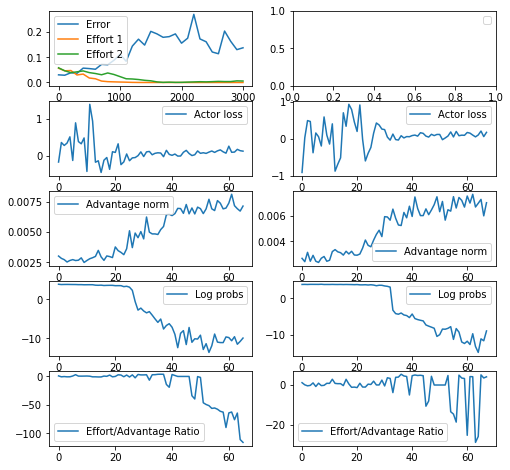

In [5]:
n_runs = len(trained_agents1)
fig, ax = plt.subplots(5,2, figsize=(8,8))
if n_runs>1:
    raise ValueError
ax[0,0].plot(training_curves[-1][0,:], -training_curves[-1][1,:], label='Error')
ax[0,0].plot(training_curves[-1][0,:], training_curves[-1][2,:], label='Effort 1')
ax[0,0].plot(training_curves[-1][0,:], training_curves[-1][3,:], label='Effort 2')
        
ax[1,0].plot(trained_agents1[-1][-1].nn_mod.logger.actorloss_ts, label='Actor loss')
ax[2,0].plot(trained_agents1[-1][-1].nn_mod.logger.adv_ts, label='Advantage norm')
ax[3,0].plot(trained_agents1[-1][-1].nn_mod.logger.logprobs_ts, label='Log probs')
ax[4,0].plot(trained_agents1[-1][-1].nn_mod.logger.eff_adv_ratio_ts, label='Effort/Advantage Ratio')

ax[1,1].plot(trained_agents2[-1][-1].nn_mod.logger.actorloss_ts, label='Actor loss')
ax[2,1].plot(trained_agents2[-1][-1].nn_mod.logger.adv_ts, label='Advantage norm')
ax[3,1].plot(trained_agents2[-1][-1].nn_mod.logger.logprobs_ts, label='Log probs')
ax[4,1].plot(trained_agents2[-1][-1].nn_mod.logger.eff_adv_ratio_ts, label='Effort/Advantage Ratio')

for _,axij in np.ndenumerate(ax):
    _ = axij.legend()

In [6]:
# test_idle_agent = rl_agent.idle_agent(None, None, None, None)#agent2.nn_mod, agent2.buffer, agent2.muscle, 1)

/u/sheybani/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ideal tracker loss =  -0.0004535951170934079
Env Reward = -0.009  Agent1 Mean Effort = 0.019  Agent2 Mean Effort = 0.023
Env Reward = -0.010  Agent1 Mean Effort = 0.018  Agent2 Mean Effort = 0.022
Env Reward = -0.012  Agent1 Mean Effort = 0.014  Agent2 Mean Effort = 0.021
Env Reward = -0.145  Agent1 Mean Effort = 0.002  Agent2 Mean Effort = 0.018
Env Reward = -0.338  Agent1 Mean Effort = 0.000  Agent2 Mean Effort = 0.001
Env Reward = -0.354  Agent1 Mean Effort = 0.000  Agent2 Mean Effort = 0.000


/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply


Env Reward = -0.356  Agent1 Mean Effort = 0.000  Agent2 Mean Effort = 0.000


/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply


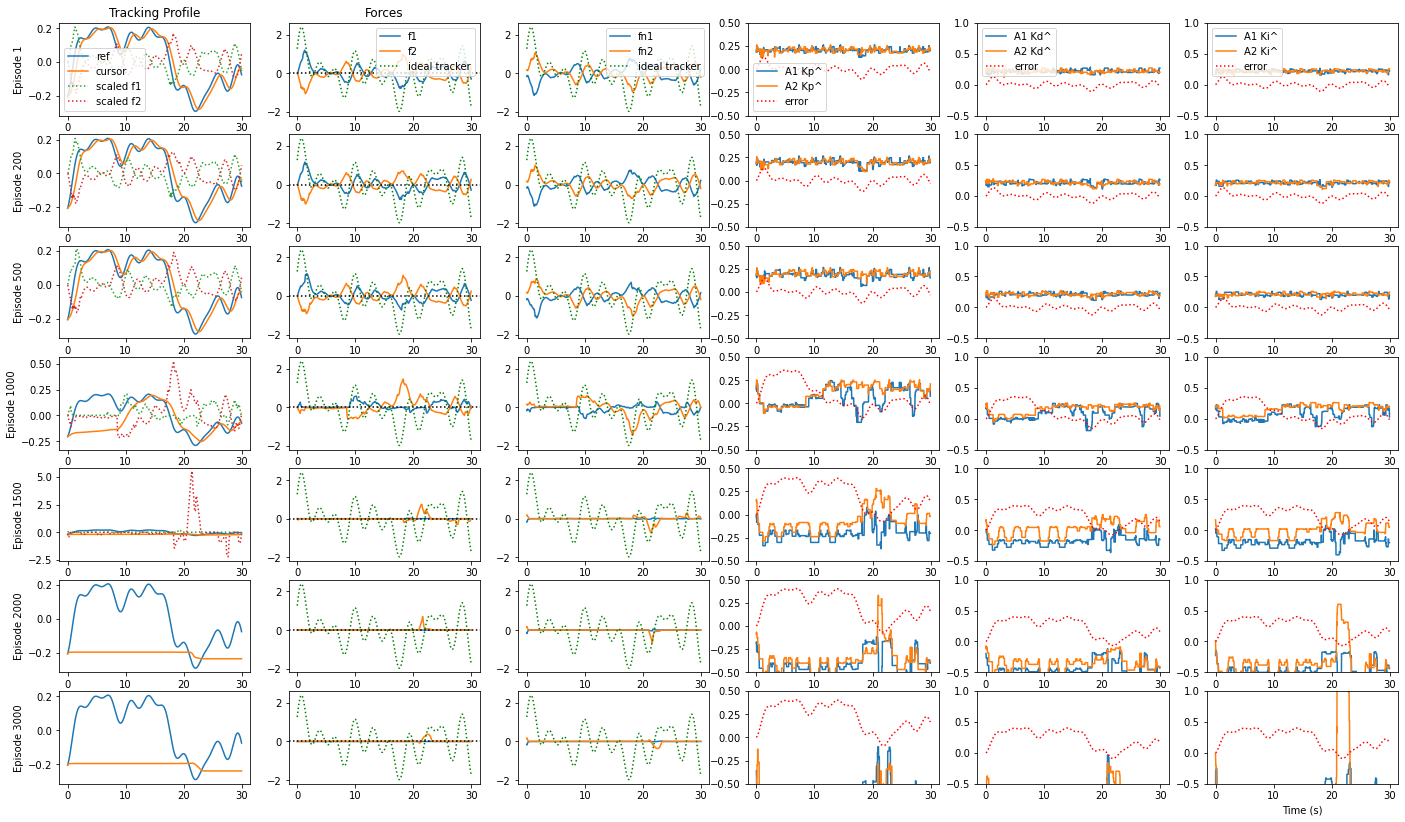

In [7]:
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
# env_test = env_track_dyadic.PhysicalTrackDyadWA(max_freq=0.5, duration=20)
env_test = env_track_dyadic.PhysicalTrackDyad_v3(max_freq=0.4, duration=30,
                                                 config_file=CONFIG_PATH+'/env_v3_config.ini')

t_ts, rx_ts, forces_ts, rewards = benchmark_agents.benchmark_force(env_test) #benchmark_agents.
ideal_prof_score = rewards[2]
print('Ideal tracker loss = ', ideal_prof_score)
ideal_force_ts = forces_ts[0]


n_runs=1
brk_pts = [1, 200, 500, 1000, 1500, 2000, 3000]#, 5000]#, 10000]

n_row = len(brk_pts) #max(len(trained_agents), 2)
n_col_type = 6
n_col = n_col_type*n_runs
fig, ax = plt.subplots(n_row, n_col, figsize=(4*n_col, int(2*n_row)))

for i in range(n_row):
   
    for j in range(n_runs):
#         t_ts, rx_ts, forces_ts, rewards = benchmark_agents.policy_ts(
#             env_test, trained_agents1[j][i], test_idle_agent, renew_traj=False, x_idx=3) 
        t_ts, rx_ts, forces_ts, rewards, actions_ts, fns_ts = benchmark_agents.policy_ts(
            env_test, trained_agents1[j][i], trained_agents2[j][i], renew_traj=False)
        
        act1_ts = np.asarray(actions_ts[0]).squeeze()
        act2_ts = np.asarray(actions_ts[1]).squeeze()
        
        fn1_ts = np.asarray(fns_ts[0]).squeeze()
        fn2_ts = np.asarray(fns_ts[1]).squeeze()
        
        rx_ts = np.asarray(rx_ts)
        
        print('Env Reward = %.3f'%rewards[2], 
              ' Agent1 Mean Effort = %.3f'%rewards[3], 
              ' Agent2 Mean Effort = %.3f'%rewards[4])
    #     fig,ax = plt.subplots(2, figsize=(6,5), sharex=True)
        ax[i,j*n_col_type].plot(t_ts, rx_ts[0,:], label='ref'); 
        ax[i,j*n_col_type].plot(t_ts, rx_ts[1,:], label='cursor')

        f_scaler = np.max(rx_ts[0])/ np.max(forces_ts[0])
        ax[i,j*n_col_type].plot(t_ts, f_scaler*np.asarray(forces_ts[0]), ls=':', label='scaled f1'); 
        ax[i,j*n_col_type].plot(t_ts, f_scaler*np.asarray(forces_ts[1]), ls=':', label='scaled f2'); 
    #     ax[i,0].legend()

        ax[i,j*n_col_type+1].plot(t_ts, forces_ts[0], label='f1'); 
        ax[i,j*n_col_type+1].plot(t_ts, forces_ts[1], label='f2'); 
        ax[i,j*n_col_type+1].plot(t_ts, ideal_force_ts, ls=':', c='g', label='ideal tracker')
        ax[i,j*n_col_type+1].axhline(y=0, ls=':', c='k')
        
        ax[i,j*n_col_type+2].plot(t_ts, fn1_ts, label='fn1'); 
        ax[i,j*n_col_type+2].plot(t_ts, fn2_ts, label='fn2'); 
        ax[i,j*n_col_type+2].plot(t_ts, ideal_force_ts, ls=':', c='g', label='ideal tracker')
        
        ax[i,j*n_col_type+3].plot(t_ts, act1_ts[:,0], label='A1 Kp^'); 
        ax[i,j*n_col_type+3].plot(t_ts, act2_ts[:,0], label='A2 Kp^');
        ax[i,j*n_col_type+3].plot(t_ts, rx_ts[0]-rx_ts[1], ls=':', c='r', label='error')
        ax[i,j*n_col_type+3].set_ylim([-0.5,0.5])
        
        ax[i,j*n_col_type+4].plot(t_ts, act1_ts[:,1], label='A1 Kd^'); 
        ax[i,j*n_col_type+4].plot(t_ts, act2_ts[:,1], label='A2 Kd^');
        ax[i,j*n_col_type+4].plot(t_ts, rx_ts[0]-rx_ts[1], ls=':', c='r', label='error')
        ax[i,j*n_col_type+4].set_ylim([-0.5,1.])
        
        ax[i,j*n_col_type+5].plot(t_ts, act1_ts[:,2], label='A1 Ki^'); 
        ax[i,j*n_col_type+5].plot(t_ts, act2_ts[:,2], label='A2 Ki^');
        ax[i,j*n_col_type+5].plot(t_ts, rx_ts[0]-rx_ts[1], ls=':', c='r', label='error')
        ax[i,j*n_col_type+5].set_ylim([-0.5,1.])
#         ax[i,j*n_col_type+2].axhline(y=0, ls=':', c='k')
        

#     ax[i,1].legend()
    
#     ax[i,2].plot(t_ts, 500*np.asarray(rewards[0]), label='E1')
#     ax[i,2].plot(t_ts, 500*np.asarray(rewards[1]), label='E2')
#     ax[i,2].axhline(y=0, ls=':', c='k')
#     ax[i,2].set_ylim([-0.1, 2.1])

# ax[2].plot(t_ts, rewards[0], label='Agent1'); ax[2].plot(t_ts, rewards[1], label='Agent2'); 
# _=ax[2].set_ylabel('Utility'); ax[2].legend()
for j in range(n_runs):
    ax[0,j*n_col_type].set_title('cp, cn = '+ run_costs[j])
        
        
#         'cp='+str(trained_agents[j][0].c_positivef)+
#                   '_cn='+str(trained_agents_resh[j][j].c_negativef));

for ii, axij in np.ndenumerate(ax[0]):
    _ = axij.legend()
ax[-1,-1].set_xlabel('Time (s)')
ax[0,0].set_title('Tracking Profile')
ax[0,1].set_title('Forces')
for i in range(len(brk_pts)):
    ax[i,0].set_ylabel('Episode '+str(brk_pts[i]))
# ax[0,2].set_title('Efforts')
# plt.savefig('traces.png', dpi=300)


In [ ]:
# pid_interp = lambda x:  x+1 if x<0 else (x+20 if x>1 else 20*x+1)
# # pid_interp_te = lambda x:  x+1 if x<0 else (x+20 if x>1 else 20*x+1)
# def pid_interp_te_depr(te, scalers=None, inplace=True):
#     if inplace:
#         te_c = te
#     else:
#         te_c = deepcopy(te)
        
#     for i, item in enumerate(te):
#         if item>0 and item<1:
#             te_c[i]= 20*item+1
#         elif item>1:
#             te_c[i]= item+20
#         else:
#             te_c[i]= item+1 
            
#     if scalers is not None:
#         return scalers *te_c
#     return te_c

# def pid_interp_te(te, scalers=None):
    
#     xtt = te>1; f_xtt = te+20
#     ytt = te<0; f_ytt = te+1
#     ztt = (te<=1) * (te>=0); f_ztt = 20*te+1
#     te_c = f_xtt*xtt + f_ytt*ytt + f_ztt*ztt
    
#     if scalers is not None:
#         return scalers *te_c
#     return te_c
    
scalers = torch.tensor([1,0.1,0.1,0.02], dtype=torch.float32)
scalers2 = torch.tensor([6.,  0.3, 0.15, 0.02*6], dtype=torch.float32)
# xtt = 3*torch.rand(4, dtype=torch.float32)
xtt = torch.tensor([.3, .3, .3, .3], dtype=torch.float32)
t0 = time.time()
for i in range(2):
#     print('Equal? ', torch.all(pid_interp_te(xtt, scalers=scalers, inplace=False)== pid_interp_te_depr(xtt, scalers=scalers, inplace=False)))
    print(pid_interp_te(xtt, scalers=scalers))
#     print(torch.exp(scalers2* xtt))
# print(time.time()-t0)

# # scalers=torch.tensor([1,0.1,0.1,1])
# t0 = time.time()
# for i in range(200):
#     torch.exp(scalers* xtt)
# print(time.time()-t0)

In [19]:
for ag in trained_agents:
    print(ag.nn_mod.actor_net.fc_mu.weight)
#     print(ag.nn_mod.actor_net.fc1.weight[0,:])

Parameter containing:
tensor([[0.0040, 0.0044, 0.0029, 0.0029, 0.0050, 0.0044, 0.0030, 0.0039, 0.0045,
         0.0040, 0.0034, 0.0038, 0.0040, 0.0018, 0.0043, 0.0036, 0.0022, 0.0035,
         0.0026, 0.0042, 0.0038, 0.0041, 0.0041, 0.0037, 0.0052, 0.0038, 0.0035,
         0.0024, 0.0049, 0.0036, 0.0044, 0.0043, 0.0036, 0.0040, 0.0041, 0.0026,
         0.0028, 0.0030, 0.0037, 0.0022, 0.0047, 0.0041, 0.0039, 0.0031, 0.0056,
         0.0037, 0.0057, 0.0023, 0.0042, 0.0018, 0.0030, 0.0036, 0.0053, 0.0051,
         0.0055, 0.0036, 0.0038, 0.0028, 0.0049, 0.0014, 0.0034, 0.0050, 0.0025,
         0.0039, 0.0050, 0.0034, 0.0056, 0.0040, 0.0027, 0.0043, 0.0048, 0.0035,
         0.0046, 0.0043, 0.0026, 0.0031, 0.0051, 0.0030, 0.0037, 0.0046, 0.0020,
         0.0042, 0.0033, 0.0040, 0.0035, 0.0040, 0.0036, 0.0032, 0.0045, 0.0052,
         0.0049, 0.0043, 0.0043, 0.0049, 0.0044, 0.0037, 0.0035, 0.0045, 0.0025,
         0.0045, 0.0034, 0.0046, 0.0043, 0.0034, 0.0048, 0.0043, 0.0042, 0.0036,
      

In [20]:
# ag.nn_mod.actor_net.fc2.weight.detach().numpy()[0,:]==ag.nn_mod.actor_net.fc2.weight.detach().numpy()[1,:]

In [30]:
n_hl=5; n_hidden=128

xtt = torch.zeros(n_hidden, n_hl)
torch.nn.init.sparse_(xtt, sparsity=1-1./(n_hl-2), std=n_hl/n_hidden)
for i in range(n_hl):
    print(torch.sum(abs(xtt[:,i])))

tensor(1.4524)
tensor(1.3201)
tensor(1.3243)
tensor(1.0135)
tensor(1.5142)


In [31]:
ag.nn_mod.actor_net.fc2.weight.detach().numpy().shape

(20, 128)

In [14]:
xtt = []
for i in range(5):
    ag = trained_agents[i]
    xtt.append(np.max(ag.nn_mod.actor_net.fc_mu.weight.detach().numpy()))
plt.plot(xtt)
plt.ylim(0,0.1)

NameError: name 'trained_agents' is not defined

In [15]:
ag = trained_agents[-1]
plt.imshow(ag.nn_mod.actor_net.fc_mu.weight.detach().numpy())
plt.colorbar()

NameError: name 'trained_agents' is not defined

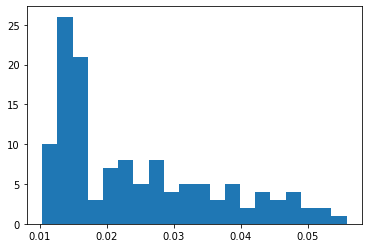

In [23]:
_ = plt.hist(ag.nn_mod.actor_net.fc_mu.weight.detach().numpy()[0,:], bins=20)

In [5]:
from collections import Mapping, Container
from sys import getsizeof
 
def deep_getsizeof(o, ids):
    """Find the memory footprint of a Python object
 
    This is a recursive function that drills down a Python object graph
    like a dictionary holding nested dictionaries with lists of lists
    and tuples and sets.
 
    The sys.getsizeof function does a shallow size of only. It counts each
    object inside a container as pointer only regardless of how big it
    really is.
 
    :param o: the object
    :param ids:
    :return:
    """
    d = deep_getsizeof
    if id(o) in ids:
        return 0
 
    r = getsizeof(o)
    ids.add(id(o))
 
    if isinstance(o, bytes) or isinstance(0, str):
        return r
 
    if isinstance(o, Mapping):
        return r + sum(d(k, ids) + d(v, ids) for k, v in o.iteritems())
 
    if isinstance(o, Container):
        return r + sum(d(x, ids) for x in o)
 
    return r 

/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  """Entry point for launching an IPython kernel.


In [6]:
# ac_size = deep_getsizeof(xagent1.nn_mod.logger.actor_weight_ts, set())
lg_content = vars(xagent1.nn_mod.logger)
lg_sizes = []
                  
for item in lg_content:
    lg_sizes.append(deep_getsizeof(lg_content[item], set()))

i=0
for item in lg_content:
    print(item, ' size = ', lg_sizes[i])
    i+=1

entropy_ts  size =  256
adv_ts  size =  256
logprobs_ts  size =  256
actor_weight_ts  size =  336
critic_weight_ts  size =  336
eff_adv_ratio_ts  size =  264
actorloss_ts  size =  256


In [7]:
# xagent1.nn_mod.actor_net.fc_mu
# xagent1.pd_scalers
# xagent1.nn_mod.actor_opt
print(xagent1.c_positivef)
print(xagent1.c_negativef)

2.0
10.0


# Put agents into a dyad

In [7]:
xagent1 = trained_agents[0][-1]
xagent2 = trained_agents[0][-1]

In [8]:
nn_mod_class = torch_trainer.MCPPOTrainer
actor_net_class = nn_models.NetContPDG5

In [9]:
from configs.fixed_exp_constants import * 

# env = env_dyadic_wa


nout = 3
ctrl_ftrs = deepcopy(xagent1.ctrl_ftrs)
# pd_scalers = [30., 30*0.025, -30*0.025]
pd_scalers = deepcopy(xagent1.pd_scalers)

ac_ftr_normalizer = deepcopy(xagent1.nn_mod.actor_net.ftr_normalizer.detach().numpy())

n_futuresteps = 20
trust_region = 0.5
n_hl=5
n_rec_actor = 0;

gamma = 0.7
device = torch.device("cpu")

n_critic_ftr = 128
n_features = 9 #+n_critic_ftr #masked features: r, r', r", f_own

actor_net1 = actor_net_class(n_features, nout, n_hidden=128, n_hl=n_hl,  
                 masked_ftrs=[], ftr_normalizer=ac_ftr_normalizer,
                                      device=device).to(device)

actor1_opt = optim.Adam([
            {'params': actor_net1.fc1.parameters(), 'lr': 1e-6},
            {'params': actor_net1.fc_mu.parameters(), 'lr': 3e-5}
        ], lr=3e-5, amsgrad=True)

actor_net1.eval(); #critic_net1.eval() #Put it to evaluation mode
n_rec_critic = 0

actor_net2 = actor_net_class(n_features, nout, n_hidden=128, n_hl=n_hl,  
                 masked_ftrs=[], ftr_normalizer=ac_ftr_normalizer,
                                      device=device).to(device)
actor2_opt = optim.Adam([
            {'params': actor_net2.fc1.parameters(), 'lr': 1e-6},
            {'params': actor_net2.fc_mu.parameters(), 'lr': 3e-5}
        ], lr=3e-5, amsgrad=True)
actor_net2.eval(); #critic_net2.eval() #Put it to evaluation mode


scheduler1 = None #optim.lr_scheduler.StepLR(optimizer1, step_size=100, gamma=0.8)
scheduler2 = None
logger1 = Logger()
logger2 = Logger()

nn_mod1 = nn_mod_class(
        actor_net1, actor1_opt, 
        n_actions=nout, trust_region=trust_region, nsteps=n_futuresteps, 
        scheduler=scheduler1, device=device, gamma=gamma,
        logger=logger1, log_weights=(n_rec_actor,n_rec_critic) ,f_ftr_idx=-1)
        
nn_mod2 = nn_mod_class(
        actor_net2, actor2_opt, 
        n_actions=nout, trust_region=trust_region, nsteps=n_futuresteps, 
        scheduler=None, device=device, gamma=gamma,
        logger=logger1, log_weights=(n_rec_actor,n_rec_critic) ,f_ftr_idx=-1)


In [10]:
actor1_statedict = deepcopy(xagent1.nn_mod.actor_net.state_dict())
actor2_statedict = deepcopy(xagent2.nn_mod.actor_net.state_dict())

nn_mod1.actor_net.load_state_dict(actor1_statedict)
nn_mod2.actor_net.load_state_dict(actor2_statedict)
nn_mod1.target_pnet.load_state_dict(deepcopy(actor1_statedict))
nn_mod2.target_pnet.load_state_dict(deepcopy(actor2_statedict))

nn_mod1.actor_net.eval(); 
nn_mod1.target_pnet.eval()
nn_mod2.actor_net.eval(); 
nn_mod2.target_pnet.eval()


NetContPDG5(
  (fc1): Linear(in_features=18, out_features=128, bias=False)
  (fc_mu): Linear(in_features=128, out_features=3, bias=False)
)

In [11]:
# agent1.nn_mod.actor_opt = optim.Adam([
#             {'params': nn_mod1.actor_net.fc1.parameters(), 'lr': 1e-6},
#             {'params': nn_mod1.actor_net.fc_mu.parameters(), 'lr': 3e-5}
#         ], lr=3e-5, amsgrad=True)

# agent2.nn_mod.actor_opt = optim.Adam([
#             {'params': nn_mod2.actor_net.fc1.parameters(), 'lr': 1e-6},
#             {'params': nn_mod2.actor_net.fc_mu.parameters(), 'lr': 3e-5}
#         ], lr=3e-5, amsgrad=True)

buffer1 = buffers.CyclicBuffer(buffer_max_size)
buffer2 = buffers.CyclicBuffer(buffer_max_size)

muscle1 = base.MuscleModel(sigma, force_max, ts=0.025, tau=tau)
muscle2 = deepcopy(muscle1)

# agent1.perspective=0
# agent2.perspective=1

# agent1.nn_mod.set_agent(agent1); agent2.nn_mod.set_agent(agent2)

In [12]:
# Run name and specs
env = env_dyadic_wa
env.duration = 15. #2*env.duration
env.max_freq = 0.5

device = torch.device("cpu")

exp_name = 'exp1.7'
target_int = 1
#     target_int_actor = 1
update_interval = int(min(batch_size/4, (env.duration-1)/env.tstep))


c_positivef1 = xagent1.c_positivef
c_negativef1 = xagent1.c_negativef

c_positivef2 = xagent2.c_positivef
c_negativef2 = xagent2.c_negativef

datinow = datetime.datetime.now();
cost_token = 'cp'+str(c_positivef1)+'cn'+str(c_negativef1)+\
            'cp'+str(c_positivef2)+'cn'+str(c_negativef2)
run_token = cost_token+'_'+datinow.strftime("%H.%M.%S") 


# hyperparams = BMHyperparams(batch_size, learning_rate, 
#                 buffer_max_size, experience_sift_tol, target_int, gamma)
agent1_mass, agent1_fric = 0.1*env.obj_mass, 0.1*env.obj_fric 
agent2_mass, agent2_fric = 0.1*env.obj_mass, 0.1*env.obj_fric 

agent1 = rl_agent.PPO5PDAgent_wfn(
    nn_mod1, buffer1, muscle1, perspective=0, hyperparams=xagent1.hp, 
    c_error=1., c_positivef=c_positivef1, c_negativef=c_negativef1, 
    ctrl_ftrs=ctrl_ftrs, pd_scalers=pd_scalers, force_rms=1., 
    mass=agent1_mass, fric=agent1_fric)

agent2 = rl_agent.PPO5PDAgent_wfn(
    nn_mod2, buffer2, muscle2, perspective=1, hyperparams=xagent2.hp, 
    c_error=1., c_positivef=c_positivef2, c_negativef=c_negativef2, 
    ctrl_ftrs=ctrl_ftrs, pd_scalers=pd_scalers, force_rms=1., 
    mass=agent2_mass, fric=agent2_fric)

# # agent2 = rl_agent.idle_agent(nn_mod2, buffer2, muscle2, perspective=1, c_error=1.,
# #                                  c_effort=1, c_negativef=c_negativef2, force_rms=1.) 
nn_mod1.set_agent(agent1); nn_mod2.set_agent(agent2)

agent1.set_train_hyperparams(xagent1.hp)
agent2.set_train_hyperparams(xagent2.hp)

algo = train_agents.train_dyad5 #train_single3# #@@@@@@@@@@@@@@@@@@@@@@


#------------ Benchmark: 

#algo, hp, env, agent1, agent2, xaxis_params
hp = xagent1.hp

# Unzip arguments
n_episodes, n_intervals, n_eval = xaxis_params


/nfs/nfs7/home/sheybani/GitRepos/B659-RL-Project/new_version/agents/rl_agent.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pd_scalers = torch.tensor(pd_scalers, device=self.nn_mod.device)


In [26]:
n_episodes = 500; n_intervals = int(n_episodes/100)
int_episodes=int(n_episodes/n_intervals)

ret_utils = True
x, y = np.zeros(n_intervals+1), np.zeros(n_intervals+1)
util1, util2 = np.zeros(n_intervals+1), np.zeros(n_intervals+1)

x[0] = 0
y[0], util1[0], util2[0] = benchmark_agents.dyad_eval(
    env, agent1, agent2, n_episodes=5, normalizer=True, 
    ret_utils=ret_utils)


In [27]:
t0 = time.time()
# Evaluate the created policy once every int_episodes episodes
for i in range(n_intervals):
    print('--------------------------------')
    print('Episode', i*int_episodes, ': Objective = %.3f'%y[i], 
          'Agent 1 Utility = %.3f'%util1[i], 
          'Agent 2 Utility = %.3f'%util2[i])
    print('env duration = ', env.traj_time[-1])
    for j in range(int_episodes):
        agent1, agent2 = algo(
            env, agent1, agent2, update_interval=update_interval, 
            current_performance=y[i])

        if hp.target_int <= 1:
            agent1.update_target_nets()
            agent2.update_target_nets()
        elif (i*int_episodes+j) % hp.target_int == 0:
            agent1.update_target_nets()
        elif (i*int_episodes+j) % hp.target_int == int(hp.target_int/2):
            agent2.update_target_nets()

#         if (i*int_episodes+j) in rec_points:
#             x_s, y_s, agent1_s, agent2_s = deepcopy(x), deepcopy(y), deepcopy(agent1), deepcopy(agent2)
#             agent1_s.buffer = buffers.CyclicBuffer(1); agent2_s.buffer = buffers.CyclicBuffer(1);
#             try:
#                 os.makedirs('data/'+data_subdir)
#             except FileExistsError:
#                 pass
#             fname = exp_name+run_token+'-'+'{:04d}'.format(i*int_episodes+j)
#             pickle.dump((x_s, y_s, agent1_s, agent2_s), open( "data/"+data_subdir+fname, "wb" ) )
                
    x[i+1] = (i+1)*int_episodes
    y[i+1], util1[i+1], util2[i+1] = benchmark_agents.dyad_eval(
        env, agent1, agent2, n_episodes=n_eval, normalizer=True, 
        ret_utils=ret_utils)

    ct = time.time()
    estimated_time_left = (n_intervals-i)*(ct-t0)/((i+1)*60)
    print('Estimated time left: %.1f' %estimated_time_left, 'minutes')
        
    
print('Total Duration: ', (ct- t0)/60, ' Minutes')

--------------------------------
Episode 0 : Objective = -0.134 Agent 1 Utility = -1110.417 Agent 2 Utility = -1066.465
env duration =  14.975000000000001
# Agent  2 Actor loss = -13.693 Critic error norm= 0.050 Log Effort / Reward mean, std, skew = 15.80 8.25 -3.26 Log probs Median =  -30.740 Entropy = -2.651
# Agent  2 Actor loss = 5.312 Critic error norm= 0.055 Log Effort / Reward mean, std, skew = 9.45 5.34 0.01 Log probs Median =  -31.340 Entropy = -2.651
# Agent  1 Actor loss = -34.069 Critic error norm= 0.049 Log Effort / Reward mean, std, skew = 16.16 8.72 -4.70 Log probs Median =  -55.572 Entropy = -2.651
# Agent  2 Actor loss = 5.069 Critic error norm= 0.046 Log Effort / Reward mean, std, skew = 9.88 5.18 0.00 Log probs Median =  -46.958 Entropy = -2.651
# Agent  1 Actor loss = 3.096 Critic error norm= 0.045 Log Effort / Reward mean, std, skew = 9.83 5.29 0.01 Log probs Median =  -41.784 Entropy = -2.651
Action Std =  tensor([[0.1000, 0.1000, 0.1000]])
# Agent  1 Actor loss =

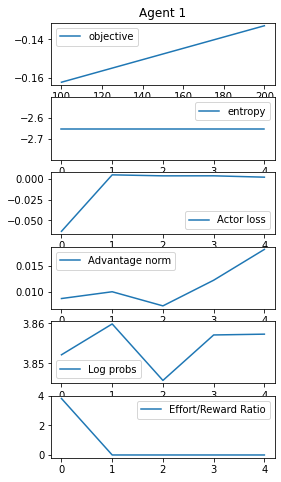

In [9]:
loggers = [xagent1.nn_mod.logger, agent2.nn_mod.logger]
x,y = x1,y1

fig, ax = plt.subplots(6,1, figsize=(4, 8))
ax[0].plot(x[1:], y[1:], label='objective')
# ax[0,1].plot(x[1:], util1[1:], label='Agent 1 utility')
# ax[0,1].plot(x[1:], util2[1:], label='Agent 2 utility')

for i in range(1):
    ax[1].plot(loggers[i].entropy_ts, label='entropy')
#     ax[1,i].set_ylim([-5.,1.]); 

    ax[2].plot(loggers[i].actorloss_ts, label='Actor loss')
#     ax[2].set_ylim([-0.05, 0.05]); #ax[2].axhline(y=0)

    ax[3].plot(loggers[i].adv_ts, label='Advantage norm')
#     ax[3,i].set_ylim([0.,10.]); #ax[2].axhline(y=0)

    ax[4].plot(loggers[i].logprobs_ts, label='Log probs')
#     ax[4].set_ylim([-2.,0.5]); ax[4].axhline(y=0)
    
    ax[5].plot(loggers[i].eff_adv_ratio_ts, label='Effort/Reward Ratio')
#     ax[4,i].set_ylim([-2.,0.5]); ax[3,i].axhline(y=0)
for _,axs in np.ndenumerate(ax):
    axs.legend()
ax[0].set_title('Agent 1');#ax[0,1].set_title('Agent 2')

Text(0.5, 1.0, 'Agent 2')

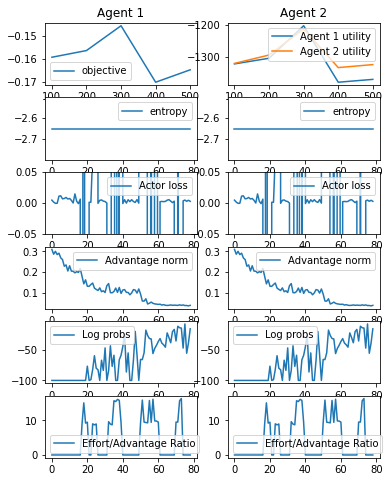

In [28]:
loggers = [agent1.nn_mod.logger, agent2.nn_mod.logger]

fig, ax = plt.subplots(6,2, figsize=(6, 8))
ax[0,0].plot(x[1:], y[1:], label='objective')
ax[0,1].plot(x[1:], util1[1:], label='Agent 1 utility')
ax[0,1].plot(x[1:], util2[1:], label='Agent 2 utility')

for i in range(2):
    ax[1,i].plot(loggers[i].entropy_ts, label='entropy')
#     ax[1,i].set_ylim([-5.,1.]); 

    ax[2,i].plot(loggers[i].actorloss_ts, label='Actor loss')
    ax[2,i].set_ylim([-0.05, 0.05]); #ax[2].axhline(y=0)

    ax[3,i].plot(loggers[i].adv_ts, label='Advantage norm')
#     ax[3,i].set_ylim([0.,10.]); #ax[2].axhline(y=0)

    ax[4,i].plot(loggers[i].logprobs_ts, label='Log probs')
#     ax[4,i].set_ylim([-2.,0.5]); ax[4,i].axhline(y=0)
    
    ax[5,i].plot(loggers[i].eff_adv_ratio_ts, label='Effort/Advantage Ratio')
#     ax[4,i].set_ylim([-2.,0.5]); ax[3,i].axhline(y=0)
for _,axs in np.ndenumerate(ax):
    axs.legend()
ax[0,0].set_title('Agent 1');ax[0,1].set_title('Agent 2')

In [ ]:
# # in init
# traj_creator = Trajectory(self.tstep, seed_=seed_)
# self.traj_time, self.traj = None, None
    
# # in reset
# if (renew_traj is False and self.traj is None) or \
#         (renew_traj is True):
#             # generate a traj
#             self.traj_time, self.traj = self.traj_creator.generate_random(self.duration, \
#                 n_traj=1, max_amp=self.max_ref, traj_max_f=traj_max_f, rel_amps=None, fixed_effort=False, \
#                 obj_mass=self.obj_mass, obj_fric=self.obj_fric, n_deriv=2, ret_specs=False)

/u/sheybani/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Env Reward = -0.242  Agent1 Mean Utility = 2099.486  Agent2 Mean Utility = 2058.930
Action Std =  tensor([[0.1000, 0.1000, 0.1000]])
Env Reward = -0.237  Agent1 Mean Utility = 2080.261  Agent2 Mean Utility = 2002.354


Text(0.5, 0, 'Time (s)')

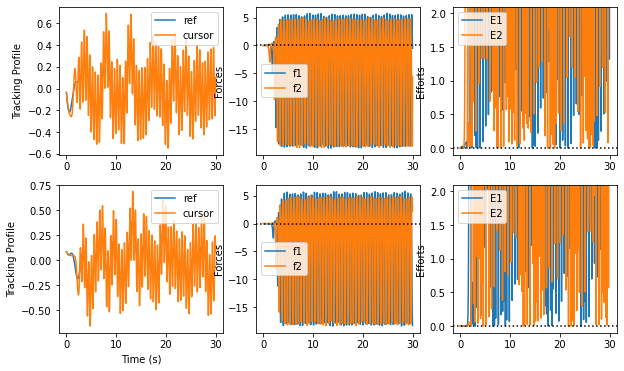

In [32]:
# x_fpx,y_fpx, agent1_fpx, agent2_fpx = x,y,agent1, agent2

# seed_=1827

# env_test = env_spring.PhysicalTrackSpringWA(max_freq=0.4, 
#                                      spring_k=0., duration=50)#, mass=0.1, fric=0.2) 
%matplotlib inline
import matplotlib.pyplot as plt
env_test = env_track_dyadic.PhysicalTrackDyadWA(max_freq=0.5, duration=30)

# env = env_spring.PhysicalTrackSpring(seed_=seed, max_ref=0.4, 
#                                      max_freq=0.2, spring_k=0.1) 
# agent1, agent2 = agent1_fp11, agent2_fp11
n_plots = 2
fig, ax = plt.subplots(n_plots,3, figsize=(10,int(3*n_plots)))


for i in range(n_plots):
    t_ts, rx_ts, forces_ts, rewards = benchmark_agents.policy_ts(
        env_test, agent1, agent2, x_idx=3) 

    print('Env Reward = %.3f'%rewards[2], 
          ' Agent1 Mean Utility = %.3f'%rewards[3], 
          ' Agent2 Mean Utility = %.3f'%rewards[4])
#     fig,ax = plt.subplots(2, figsize=(6,5), sharex=True)
    ax[i,0].plot(t_ts, rx_ts[0], label='ref'); 
    ax[i,0].plot(t_ts, rx_ts[1], label='cursor')
    ax[i,0].set_ylabel('Tracking Profile');
    
    f_scaler = np.max(rx_ts[0])/ np.max(forces_ts[0])
#     ax[i,0].plot(t_ts, f_scaler*np.asarray(forces_ts[0]), ls=':', label='scaled f1'); 
#     ax[i,0].plot(t_ts, f_scaler*np.asarray(forces_ts[1]), ls=':', label='scaled f2'); 
    ax[i,0].legend()

    ax[i,1].plot(t_ts, forces_ts[0], label='f1'); 
    ax[i,1].plot(t_ts, forces_ts[1], label='f2'); 
    ax[i,1].axhline(y=0, ls=':', c='k')
    ax[i,1].set_ylabel('Forces'); ax[i,1].legend()
    
    ax[i,2].plot(t_ts, 1*np.asarray(rewards[0]), label='E1')
    ax[i,2].plot(t_ts, 1*np.asarray(rewards[1]), label='E2')
    ax[i,2].axhline(y=0, ls=':', c='k')
    ax[i,2].set_ylabel('Efforts'); ax[i,2].legend()
    ax[i,2].set_ylim([-0.1, 2.1])

# ax[2].plot(t_ts, rewards[0], label='Agent1'); ax[2].plot(t_ts, rewards[1], label='Agent2'); 
# _=ax[2].set_ylabel('Utility'); ax[2].legend()
ax[-1,0].set_xlabel('Time (s)')
# plt.savefig('dqn_exp1example.pdf')

In [36]:
np.all(agent1.nn_mod.actor_net.fc_mu.weight.detach().numpy()==xagent1.nn_mod.actor_net.fc_mu.weight.detach().numpy())

False

In [43]:
f1_ts = np.asarray(forces_ts[0]);
f2_ts = np.asarray(forces_ts[1]);

print('f1 mean = %.2f' %np.mean(f1_ts))
print('positive f1 mean, std = %.2f, %.2f' % ( np.mean(f1_ts[f1_ts>0]), np.std(f1_ts[f1_ts>0])))
print('negative f1 mean, std = %.2f, %.2f' % ( np.mean(f1_ts[f1_ts<0]), np.std(f1_ts[f1_ts<0]) ) )

print('f2 mean = %.2f'%np.mean(f2_ts))
print('positive f2 mean, std = %.2f, %.2f' % ( np.mean(f2_ts[f2_ts>0]), np.std(f2_ts[f2_ts>0])  ))
print('negative f2 mean, std = %.2f, %.2f' % ( np.mean(f2_ts[f2_ts<0]), np.std(f2_ts[f2_ts<0])  ))

f1 mean = -0.04
positive f1 mean, std = 0.08, 0.04
negative f1 mean, std = -0.16, 0.12
f2 mean = -0.02
positive f2 mean, std = 0.10, 0.05
negative f2 mean, std = -0.14, 0.10


In [8]:
test_idle_agent = rl_agent.idle_agent(agent2.nn_mod, agent2.buffer, agent2.muscle, 1)

/u/sheybani/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Env Reward = -0.240  Agent1 Mean Utility = 0.000  Agent2 Mean Utility = 0.000


/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


Env Reward = -0.651  Agent1 Mean Utility = 0.000  Agent2 Mean Utility = 0.000


/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


Env Reward = -0.239  Agent1 Mean Utility = 0.000  Agent2 Mean Utility = 0.000


/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/l/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


Text(0.5, 0, 'Time (s)')

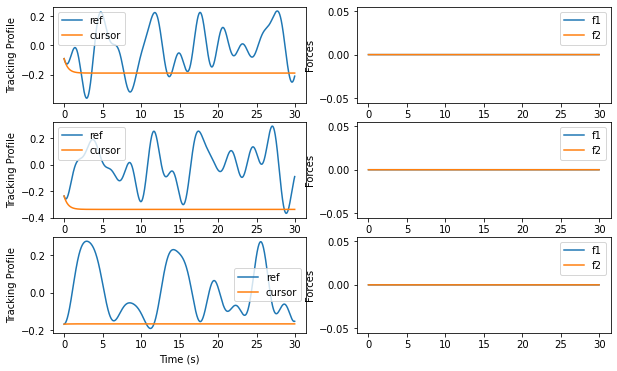

In [9]:
# x_fpx,y_fpx, agent1_fpx, agent2_fpx = x,y,agent1, agent2

# seed_=1827

# env_test = env_spring.PhysicalTrackSpringWA(max_freq=0.4, 
#                                      spring_k=0., duration=50)#, mass=0.1, fric=0.2) 
env_test = env_track_dyadic.PhysicalTrackDyadWA(max_freq=0.4, duration=30)

# env = env_spring.PhysicalTrackSpring(seed_=seed, max_ref=0.4, 
#                                      max_freq=0.2, spring_k=0.1) 
# agent1, agent2 = agent1_fp11, agent2_fp11
n_plots = 3
fig, ax = plt.subplots(n_plots,2, figsize=(10,int(2*n_plots)))


for i in range(n_plots):
    t_ts, rx_ts, forces_ts, rewards = benchmark_agents.policy_ts(
        env_test, agent1, test_idle_agent, x_idx=3) 

    print('Env Reward = %.3f'%rewards[2], ' Agent1 Mean Utility = %.3f'%rewards[3], ' Agent2 Mean Utility = %.3f'%rewards[4])
#     fig,ax = plt.subplots(2, figsize=(6,5), sharex=True)
    ax[i,0].plot(t_ts, rx_ts[0], label='ref'); 
    ax[i,0].plot(t_ts, rx_ts[1], label='cursor')
    ax[i,0].set_ylabel('Tracking Profile'); ax[i,0].legend()
    
    f_scaler = np.max(rx_ts[0])/ np.max(forces_ts[0])
    ax[i,0].plot(t_ts, f_scaler*np.asarray(forces_ts[0]), ls=':', label='scaled f1'); 
    ax[i,0].plot(t_ts, f_scaler*np.asarray(forces_ts[1]), ls=':', label='scaled f2'); 

    ax[i,1].plot(t_ts, forces_ts[0], label='f1'); 
    ax[i,1].plot(t_ts, forces_ts[1], label='f2'); 
    ax[i,1].set_ylabel('Forces'); ax[i,1].legend()

# ax[2].plot(t_ts, rewards[0], label='Agent1'); ax[2].plot(t_ts, rewards[1], label='Agent2'); 
# _=ax[2].set_ylabel('Utility'); ax[2].legend()
ax[-1,0].set_xlabel('Time (s)')
# plt.savefig('dqn_exp1example.pdf')

In [10]:
ac1_weight1_ts = np.array(loggers[0].actor_weight_ts[0])
ac1_gradients1_ts = np.diff(ac1_weight1_ts, n=1, axis=0)

# ac2_weight1_ts = np.array(loggers[1].actor_weight_ts[0])
# ac2_gradients1_ts = np.diff(ac2_weight1_ts, n=1, axis=0)
ac1_weight2_ts = np.array(loggers[0].actor_weight_ts[1])
ac1_gradients2_ts = np.diff(ac1_weight2_ts, n=1, axis=0)

ac1_w1_change = ac1_weight1_ts[-1,...]-ac1_weight1_ts[0,...]
ac1_w2_change = ac1_weight2_ts[-1,...]-ac1_weight2_ts[0,...]

ac1_weight3_ts = np.array(loggers[0].actor_weight_ts[2])
# ac1_w3_change = ac1_weight3_ts[-1,...]-ac1_weight3_ts[0,...]

In [11]:
print(agent1.nn_mod.actor_net.named_modules)
print('ac1_weight1_ts shape: ', ac1_weight1_ts.shape)
print('ac1_weight2_ts shape: ', ac1_weight2_ts.shape)
print('ac1_weight3_ts shape: ', ac1_weight3_ts.shape)

<bound method Module.named_modules of NetContPDG(
  (fc1): Linear(in_features=9, out_features=128, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=False)
  (fc_mu): Linear(in_features=5, out_features=3, bias=False)
)>
ac1_weight1_ts shape:  (49795, 3, 5)
ac1_weight2_ts shape:  (49795, 5, 64)
ac1_weight3_ts shape:  (0,)


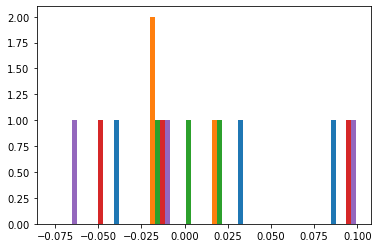

In [21]:
_ = plt.hist(agent1.nn_mod.actor_net.fc_mu.weight.detach().numpy())

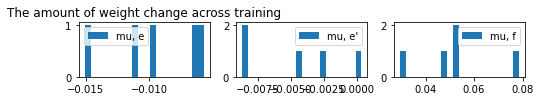

In [12]:
fig, ax = plt.subplots(1,3, figsize=(8,1))
# _ = ax[0,0].hist(ac1_w1_change[0,:], bins=20, label='std, e')
# _ = ax[0,1].hist(ac1_w1_change[1,:], bins=20, label='std, edot')
_ = ax[0].hist(ac1_w1_change[0,:], bins=20, label='mu, e')
_ = ax[1].hist(ac1_w1_change[1,:], bins=20, label='mu, e\'')
_ = ax[2].hist(ac1_w1_change[2,:], bins=20, label='mu, f')
ax[0].set_title('The amount of weight change across training')
for i, axij in np.ndenumerate(ax):
    axij.legend()

In [13]:
print('The parameters of p^, d^, f^ :', agent1.nn_mod.actor_net.fc_mu.weight)
print('The parameters of p^, d^, f^ :', agent2.nn_mod.actor_net.fc_mu.weight)

The parameters of p^, d^, f^ : Parameter containing:
tensor([[ 0.0414, -0.0073, -0.0104, -0.0481, -0.0787],
        [-0.0280, -0.0122,  0.0124, -0.0142, -0.0176],
        [ 0.0939,  0.0286, -0.0014,  0.0939,  0.1011]], requires_grad=True)
The parameters of p^, d^, f^ : Parameter containing:
tensor([[ 0.0414, -0.0073, -0.0104, -0.0481, -0.0787],
        [-0.0280, -0.0122,  0.0124, -0.0142, -0.0176],
        [ 0.0939,  0.0286, -0.0014,  0.0939,  0.1011]], requires_grad=True)


In [13]:
print('The parameters of p^, d^, f^ :', xagent1.nn_mod.actor_net.fc_mu.weight)

The parameters of p^, d^, f^ : Parameter containing:
tensor([[0.1317, 0.1105, 0.1979],
        [0.1786, 0.1721, 0.2144],
        [0.1688, 0.2392, 0.1959]], requires_grad=True)


### Saving the data without the unnecessary components

In [14]:
agent1.nn_mod.logger = Logger()
agent2.nn_mod.logger = Logger()

agent1.buffer = buffers.CyclicBuffer(1)
agent2.buffer = buffers.CyclicBuffer(1)

In [15]:
# pickle.dump((x, y, util1, util2, agent1, agent2), open( "data/"+exp_name+run_token+"results.p", "wb" ) )
pickle.dump((x, y, agent1, agent2), open( "data/"+exp_name+run_token+"results.p", "wb" ) )

### PCA Analysis of the networks

In [10]:
import pandas as pd
from copy import deepcopy
import sklearn
from sklearn import linear_model
from sklearn.decomposition import PCA

from sklearn import manifold, cluster

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns
import scipy
from IPython.display import display, Latex, Markdown
from functools import partial
# from sklearn.tree import DecisionTreeRegressor

In [11]:
# helper funcs
def list2str(lst):
    str_out=""
    for item in lst:
        str_out += " %.2f;"%item
    return str_out    
    
def ftr2str(lst):
    str_out = "r= %.1f r\'= %.1f e= %.1f e\'= %.1f f= %.1f "%(lst[0], lst[1], lst[2], lst[3], lst[6]) 
    return str_out



### Fitting one regressor to each point

def get_neighborhood_offsets(n_ftr=7, radius=0.05):
    
    vals = [[-radius,radius]]*n_ftr
    
    neighborhood=[]
    
    def expand(tree, i,j):
#         print('expanding index ', i, ' ',j)
        tree.append(vals[i][j])
        if i+1<len(vals):
            for j in range(len(vals[i+1])):
                expand(deepcopy(tree), i+1,j)
        else:
            neighborhood.append(tree)
#             print('tree added')

    expand([],0,0)
    expand([],0,1)
    
    return neighborhood

In [12]:
# Approach 2: collect the data points from simulations

def collect_supervised_data_pdg(env, agent1, agent2, duration=50., ds_rate=10, 
                                ret_z=True, ret_agent2_vars=False):
    # Collects the features and actions happening in one episode.
    # ds_rate: the interval between the collected time steps.
    eps=0; verbose=True
    
    observations = env.reset(renew_traj=True);# 
    agent1.reset(); agent2.reset()
    
    old_observations = np.asarray(observations)
    
    state1_old = agent1.observe(old_observations); state2_old = agent2.observe(old_observations)
    
    f1, action1 = agent1.get_force(state1_old, eps=eps, verbose=verbose)
    f2, action2 = agent2.get_force(state2_old, eps=eps, verbose=verbose)
    
    t_ts=[]
    cum_reward = 0.
    
    state1_ts, force1_ts, action1_ts, hiddens1_ts, val1_ts, u1_ts = [], [], [], [], [], []
    state2_ts, force2_ts, action2_ts, hiddens2_ts, val2_ts, u2_ts = [], [], [], [], [], []
    
    while True:
        t = env.get_time()
        observations, reward, done, _ = env.step([f1, f2])
    
        cum_reward += reward
        
        state1 = agent1.observe(observations); state2 = agent2.observe(observations)
        f1, action1 = agent1.get_force(state1, eps=eps, verbose=verbose)
        f2, action2 = agent2.get_force(state2, eps=eps, verbose=verbose)
        
        # Get hidden variable
        state1_tar = torch.as_tensor(state1, dtype=torch.float32).view(1,-1)
        _, hiddens1 = agent1.nn_mod.actor_net.forward(state1_tar, eps=eps, verbose=verbose)
#         val1 = agent1.nn_mod.critic_net.forward(state1_tar)
        
        if ret_agent2_vars:
            state2_tar = torch.as_tensor(state2, dtype=torch.float32).view(1,-1)
            _, hiddens2 = agent2.nn_mod.actor_net.forward(state2_tar, eps=eps, verbose=verbose)
#             val2 = agent2.nn_mod.critic_net.forward(state2_tar)
        
        
        if t % ds_rate==0:
            state1_ts.append(state1); 
            action1_ts.append(action1[0])
            hiddens1_ts.append(hiddens1)
            force1_ts.append(f1)
#             val1_ts.append(val1.item())
            u1_ts.append(agent1._compute_effort(f1))
            
            if ret_agent2_vars:
                state2_ts.append(state2); 
                action2_ts.append(action2[0])
                hiddens2_ts.append(hiddens2)
                force2_ts.append(f2)
#                 val2_ts.append(val2.item())
                u2_ts.append(agent2._compute_effort(f2))

        if done is True:
            break

    t_ts = [t_i*env.tstep for t_i in t_ts]
    
    if ret_z: 
        if ret_agent2_vars:
            return (state1_ts, action1_ts, hiddens1_ts, force1_ts, u1_ts), (state2_ts, action2_ts, hiddens2_ts, force2_ts, u2_ts)
        else:
            return (state1_ts, action1_ts, hiddens1_ts, force1_ts, u1_ts), _
    return state1_ts, action1_ts



# def get_regressor_pdg(point, offsets, ctrl_ftrs=slice(3,6)):
    
#     neighborhood = point+offsets
#     stt = torch.FloatTensor(neighborhood)
# #     outputs = agent1.nn_mod.actor_net(stt).loc.detach().numpy()
#     mu, = agent1.nn_mod.actor_net.forward(stt, eps=0, verbose=True)
#     actions = dists.loc.detach().numpy()
#     regr = linear_model.LinearRegression(fit_intercept=False).fit(neighborhood[:,ctrl_ftrs], actions)
#     regr_hidden = linear_model.LinearRegression().fit(neighborhood, z3)#.detach().numpy())
    
#     return np.append(regr.coef_, regr.intercept_), np.append(regr_hidden.coef_, regr_hidden.intercept_)

In [13]:
# agent2 = rl_agent.idle_agent(agent2.nn_mod, agent2.buffer, agent2.muscle, 1)

In [14]:
collect_supervised_data = collect_supervised_data_pdg
# get_regressor = partial(get_regressor_pdg, ctrl_ftrs=agent1.nn_mod.actor_net.ctrl_ftr_i)

In [15]:
# agent1 = trained_agents[-1] 
# agent2 = test_idle_agent 
agent1 = trained_agents1[-1][-1]
agent2 = trained_agents2[-1][-1]

In [16]:
# env1_test = env_spring.PhysicalTrackSpring(max_freq=0.5, 
#                                            spring_k=0., duration=10)#, mass=0.1, fric=0.2) 
# env2_test = env_spring.PhysicalTrackSpring(max_freq=0.2, 
#                                            spring_k=0., duration=10)#, mass=0.1, fric=0.2) 
n_sp_episodes = 200;
ret_agent2_vars = True

a1_all_vars = [[] for i in range(5)]
a2_all_vars = [[] for i in range(5)]

# xfeatures1=[];xactions1=[]; xhiddens1=[]; xforces1=[]; xvals1=[];
# xfeatures2=[];xactions2=[]; xhiddens2=[]; xforces2=[]; xvals2=[];

for i in range(n_sp_episodes):
    if i%5==0:
        print('i = ', i)
#     env1_test = env_track_dyadic.PhysicalTrackDyadWA(max_freq=0.5*np.random.rand(), 
#                                            duration=10)#, mass=0.1, fric=0.2) 
    env1_test = env_track_dyadic.PhysicalTrackDyad_v3(max_freq=0.5*np.random.rand(), duration=10,
                                                 config_file='configs/env_v3_config.ini')
#     xfeatures01, xactions01, xhiddens01,xforces01, xvals01 = collect_supervised_data(
#         env1_test, agent1, agent2, ret_z=True)
    a1_vars, a2_vars = collect_supervised_data(
        env1_test, agent1, agent2, ret_z=True, ret_agent2_vars=ret_agent2_vars, ds_rate=1)
    
    for j, var_chunk in enumerate(a1_vars):
        a1_all_vars[j] = a1_all_vars[j]+ var_chunk
        
    if ret_agent2_vars:
        for j, var_chunk in enumerate(a2_vars):
            a2_all_vars[j] = a2_all_vars[j]+ var_chunk

i =  0


/u/sheybani/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


i =  5
i =  10
i =  15
i =  20
i =  25
i =  30
i =  35
i =  40
i =  45
i =  50
i =  55
i =  60
i =  65
i =  70
i =  75
i =  80
i =  85
i =  90
i =  95
i =  100
i =  105
i =  110
i =  115
i =  120
i =  125
i =  130
i =  135
i =  140
i =  145
i =  150
i =  155
i =  160
i =  165
i =  170
i =  175
i =  180
i =  185
i =  190
i =  195


In [17]:
# Single agent identification

# # env1_test = env_spring.PhysicalTrackSpring(max_freq=0.5, 
# #                                            spring_k=0., duration=10)#, mass=0.1, fric=0.2) 
# # env2_test = env_spring.PhysicalTrackSpring(max_freq=0.2, 
# #                                            spring_k=0., duration=10)#, mass=0.1, fric=0.2) 
# n_sp_episodes = 200;
# ret_agent2_vars = True

# xfeatures=[];xactions=[]; xhiddens=[]; xforces=[]; xvals=[];
# for i in range(n_sp_episodes):
#     if i%5==0:
#         print('i = ', i)
#     env1_test = env_track_dyadic.PhysicalTrackDyadWA(max_freq=0.5*np.random.rand(), 
#                                            duration=10)#, mass=0.1, fric=0.2) 
#     xfeatures01, xactions01, xhiddens01,xforces01, xvals01 = collect_supervised_data(
#         env1_test, agent1, agent2, ret_z=True)
#     xfeatures = xfeatures +xfeatures01#+xfeatures02;
#     xactions = xactions +xactions01#+xactions02
#     xhiddens = xhiddens +xhiddens01#+xactions02
#     xforces = xforces +xforces01
#     xvals = xvals +xvals01#+xactions02

In [18]:
def unwrap_hiddens(hiddens_ts):
    # hiddens_ts is a list of sequences. 
    # Each sequences consists of the hidden variables at time t.
    n_var = len(hiddens_ts[0])
    hidden_ts_s = [[] for i in range(n_var)]
    for hidden_pack in hiddens_ts:
        for i, hidden in enumerate(hidden_pack):
            hidden_ts_s[i].append(hidden)
    for i in range(n_var):
        hidden_ts_s[i] = np.asarray(hidden_ts_s[i])
    return hidden_ts_s

telist2nplist = lambda lst: [item.numpy() for item in lst]

In [19]:
chosen_agent = a1_all_vars

In [20]:
xfeatures = np.asarray(telist2nplist(chosen_agent[0])).squeeze()
xactions = np.squeeze(np.asarray(telist2nplist(chosen_agent[1])))
# xhiddens = unwrap_hiddens(chosen_agent[2])
xforces = np.asarray(chosen_agent[3])
xefforts = np.asarray(chosen_agent[4])

xftr_std = np.std(xfeatures, axis=0)

scaler = sklearn.preprocessing.StandardScaler(with_mean=False, with_std=True, copy=True)
xfeatures_n = scaler.fit_transform(xfeatures)
print('scales = ', scaler.scale_)
# ftr_scaler = agent1.nn_mod.actor_net.ftr_normalizer
# masked_ftrs = agent1.nn_mod.actor_net.masked_ftrs
# if len(masked_ftrs)>0:
#     raise NotImplementedError

scales =  [0.14462526 0.14183216 0.24696183 0.04913207 0.0860536  0.03902468
 0.68042337 1.         0.69448981]


Standard deviation of the features =  [0.14462507 0.14182961 0.24695584 0.04913126 0.08604968 0.03902415
 0.6804222  0.         0.6944891 ]


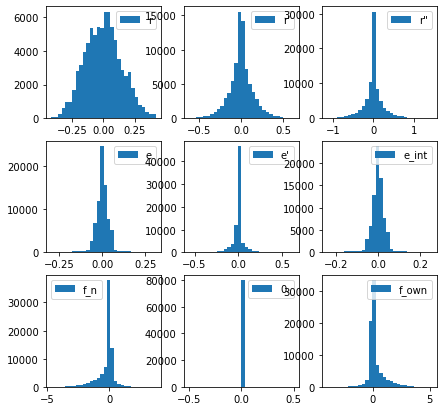

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
ftr_names = ['r', 'r\'', 'r\"', 'e', 'e\'', 'e_int', 'f_n', '0.', 'f_own']
act_names = ['p^', 'd^', 'i^','f^']
# hid_names = ['z'+str(i+1) for i in range(xhiddens[1].shape[1])]

fig, axs = plt.subplots(3,3, figsize=(7,7))

for i in range(xfeatures.shape[1]):
    ax = axs[int(i/3), i%3]
    _ = ax.hist(xfeatures[:,i], bins=30, label=ftr_names[i])
#     print('Standard deviation of '+ftr_names[i]+' = ', np.std(xfeatures[:,i]))
    ax.legend()
print('Standard deviation of the features = ', xftr_std)

<AxesSubplot:>

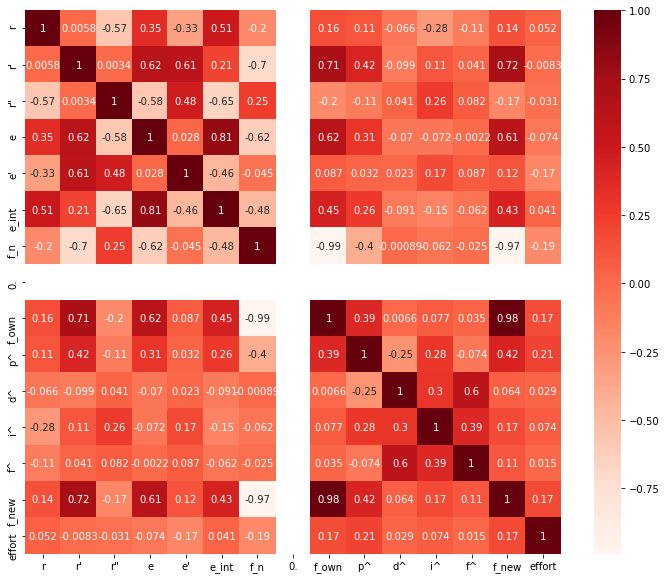

In [22]:
alldata = np.concatenate((xfeatures_n,
                          xactions,
                          xforces.reshape(-1,1),
                         xefforts.reshape(-1,1)), axis=1)
df1 = pd.DataFrame(alldata, columns=ftr_names+act_names+['f_new', 'effort'])
df1 = df1.astype(float)

%matplotlib inline
plt.figure(figsize=(12,10))
cor1 = df1.corr()
sns.heatmap(cor1, annot=True, cmap=plt.cm.Reds)
# plt.show()

In [23]:
def plot_controller_density(point_den_list,
                 figsize=(5,5), radius=1., alpha=1., **kwargs):
    
    pts, freqs = tuple(zip(*point_den_list))
    pts = np.array(pts)
    freqs = np.array(freqs)
    
    %matplotlib notebook
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax_scat = ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=radius*freqs, alpha=alpha, **kwargs)
    ax.set_xlabel('Kp^')
    ax.set_ylabel('Kd^')
    ax.set_zlabel('Ki^')


In [25]:
# Density scatter plot
from collections import Counter
xvar, yvar, zvar = df1['p^'], df1['d^'], df1['i^']
# hash0 = (1000*xvar+ 10000*yvar+ 100000*zvar).astype(int)
# cntr = Counter(hash0)
# s_cscat = [cntr[item] for item in hash0]
cntr = Counter(zip(xvar, yvar, zvar))
c_points = list(cntr.items())

<IPython.core.display.Javascript object>


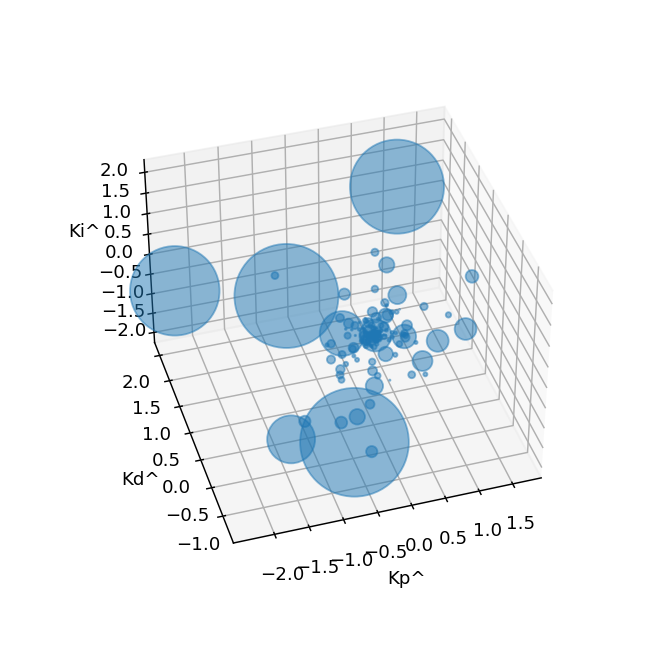

In [26]:
plot_controller_density(c_points, radius=.2, alpha=0.5)

In [28]:
# cont_pts, freqs = tuple(zip(*c_points))
# cont_pts = np.array(cont_pts)
cont_pts = df1[['p^','d^','i^']]

# DBSCAN

t0 = time.time()
clx = sklearn.cluster.DBSCAN(eps=0.1,min_samples=5, metric='euclidean').fit(cont_pts)
print(time.time()-t0)

# %matplotlib inline
# _ = plt.hist(clx.labels_)

11.643280744552612


<IPython.core.display.Javascript object>


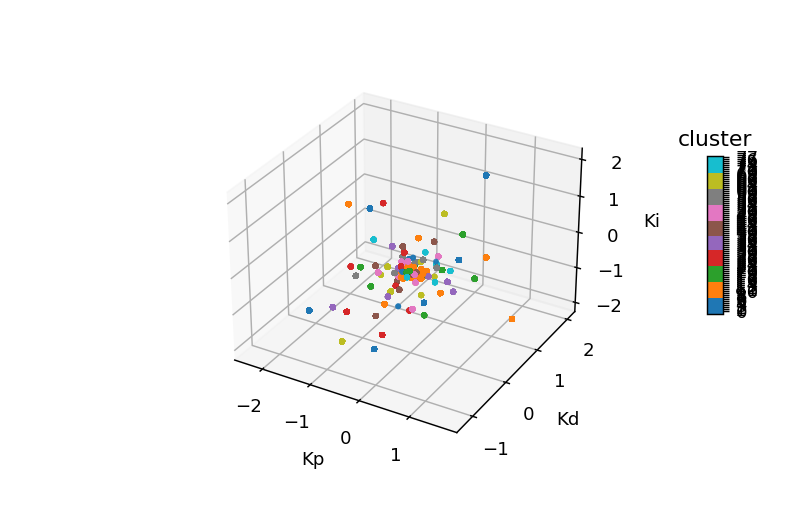

Text(0.5, 1.0, 'cluster')

In [29]:
clx = clx
n_clusters = len(np.unique(clx.labels_))
cont_labels = clx.labels_

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cl_cmap = plt.get_cmap('tab10', n_clusters)

ax_scat = ax.scatter(df1['p^'], df1['d^'], df1['i^'], c=clx.labels_, cmap=cl_cmap, s=5)
ax.set_xlabel('Kp')
ax.set_ylabel('Kd')
ax.set_zlabel('Ki')

cax1 = fig.add_axes([0.9, 0.4, 0.02, 0.3])
cbar1 = fig.colorbar(ax_scat, cax=cax1, orientation='vertical')
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cbar1.set_ticks(tick_locs)
cbar1.set_ticklabels(np.arange(n_clusters))
cax1.set_title('cluster')
# plt.scatter()

In [26]:
# Create the vector field

e_dif = df1['e'].diff().fillna(0)
ed_dif = df1['e\''].diff().fillna(0)
fn_dif = df1['f_n'].diff().fillna(0)

mode_func = lambda arr: scipy.stats.mode(arr, axis=None, nan_policy='propagate')[0][0]

In [27]:
nebins = 28
nedbins = 32
vf_means, vf_xbin_edges, vf_ybin_edges, vf_binnumber =  scipy.stats.binned_statistic_2d(
    df1['e'],df1['e\''], 
    [e_dif, ed_dif],
    statistic='mean', bins=(nebins,nedbins))

vf_eff, _, _, vf_binnumber =  scipy.stats.binned_statistic_2d(
    df1['e'],df1['e\''], 
    df1['effort'],
    statistic='mean', bins=[vf_xbin_edges, vf_ybin_edges])

vf_f, _, _, vf_binnumber =  scipy.stats.binned_statistic_2d(
    df1['e'],df1['e\''], 
    df1['f_new'],
    statistic='mean', bins=[vf_xbin_edges, vf_ybin_edges])

# vf_cont, _, _, vf_binnumber =  scipy.stats.binned_statistic_2d(
#     df1['e'],df1['e\''], 
#     cont_labels,
#     statistic=mode_func, bins=[vf_xbin_edges, vf_ybin_edges])

vf_x = np.convolve(vf_xbin_edges, [0.5,0.5], mode='valid')
vf_y = np.convolve(vf_ybin_edges, [0.5,0.5], mode='valid')
vf_stds, vf_xbin_edges, vf_ybin_edges, vf_binnumber =  scipy.stats.binned_statistic_2d(
    df1['e'],df1['e\''], 
    [e_dif, ed_dif],
    statistic='std', bins=(nebins,nedbins))

locxy_mean = []
dirxy_mean = []
dirxy_std = []
eff_mean = []
for i in range(vf_means.shape[1]):
    for j in range(vf_means.shape[2]):
        if np.isnan(vf_means[0,i,j]) == False: #!= np.isnan(vf_stats[1,i,j]):
            locxy_mean.append([vf_x[i],vf_y[j]])
            dirxy_mean.append(vf_means[:,i,j])
            dirxy_std.append(vf_stds[:,i,j])
            eff_mean.append(vf_eff[i,j])
locxy_mean = np.array(locxy_mean)
dirxy_mean = np.array(dirxy_mean) 
dirxy_std = np.array(dirxy_std)
eff_mean = np.array(eff_mean)

# locxy_std = []
# dirxy_std = []
# for i in range(vf_stds.shape[1]):
#     for j in range(vf_stds.shape[2]):
# #         print(i,j)
#         if np.isnan(vf_stds[0,i,j]) == False: #!= np.isnan(vf_stats[1,i,j]):
#             dirxy_std.append(vf_stds[:,i,j])
#             locxy_std.append([vf_x[i],vf_y[j]])
# # #             print('gotcha!')
# locxy_std = np.array(locxy_std)
# dirxy_std = np.array(dirxy_std)

<IPython.core.display.Javascript object>


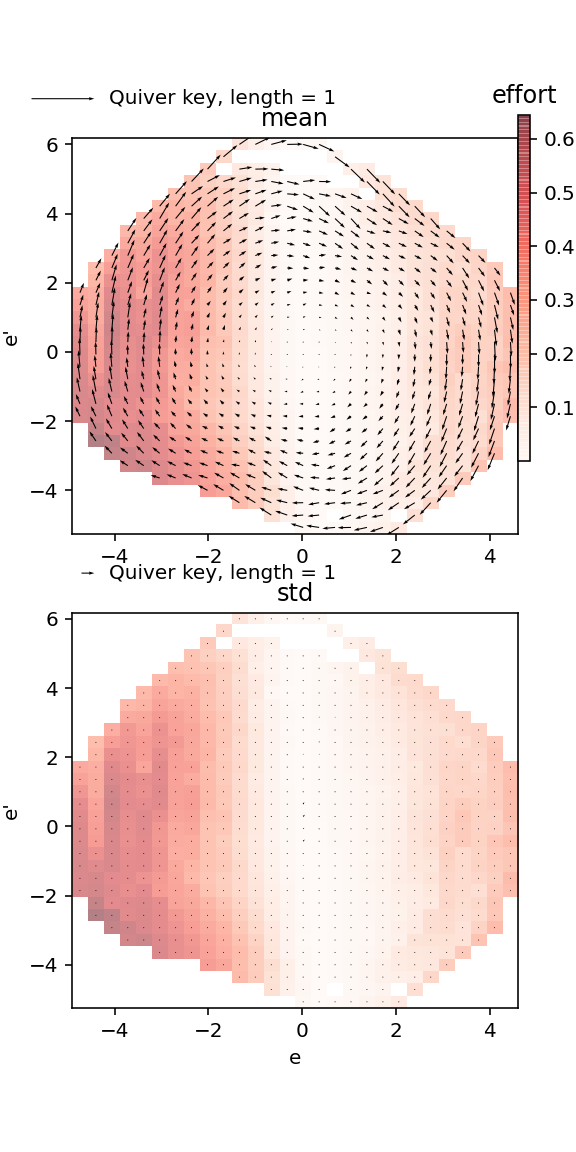

Text(0.5, 0, 'e')

In [28]:
%matplotlib notebook
fig, ax = plt.subplots(2,1, figsize=(4,8))
# im_ax = ax[0].twinx()

im_extent = (vf_xbin_edges[0], vf_xbin_edges[-1], vf_ybin_edges[0], vf_ybin_edges[-1])
ax_im = ax[0].imshow(vf_eff.T, extent=im_extent, origin='lower', cmap='Reds', alpha=0.5, aspect='auto')
# ax[0].get_xaxis().set_visible(False)
# ax[0].get_yaxis().set_visible(False)
ax[1].imshow(vf_eff.T, extent=im_extent, origin='lower', cmap='Reds', alpha=0.5, aspect='auto')
cax1 = fig.add_axes([0.9, 0.6, 0.02, 0.3])
cbar1 = fig.colorbar(ax_im, cax=cax1, orientation='vertical')
cax1.set_title('effort')
# ax[1].imshow(vf_eff, origin='lower', cmap='Reds', alpha=0.8)

colr1 = np.arctan2(dirxy_mean[:,0], dirxy_mean[:,1])
ax_q1 = ax[0].quiver(locxy_mean[:,0], locxy_mean[:,1], dirxy_mean[:,0], dirxy_mean[:,1], color='k')#colr1, cmap='hsv')
ax[0].quiverkey(ax_q1, X=0.05, Y=1.1, U=1,
             label='Quiver key, length = 1', labelpos='E')


colr2 = np.sqrt(dirxy_std[:,0]**2 + dirxy_std[:,1]**2)
ax_q2 = ax[1].quiver(locxy_mean[:,0], locxy_mean[:,1], dirxy_std[:,0], dirxy_std[:,1], 
                     color='k',
                    scale=34.8)
ax[1].quiverkey(ax_q2, X=0.05, Y=1.1, U=1,
             label='Quiver key, length = 1', labelpos='E')
# cax2 = fig.add_axes([0.9, 0.1, 0.02, 0.3])
# cbar2 = fig.colorbar(ax_q2, cax=cax2, orientation='vertical')

ax[0].set_title('mean')
ax[1].set_title('std')
ax[0].set_ylabel('e\'')
ax[1].set_ylabel('e\'')
ax[1].set_xlabel('e')

# fig.savefig('tmp_vecfield1.png', dpi=300)

<IPython.core.display.Javascript object>


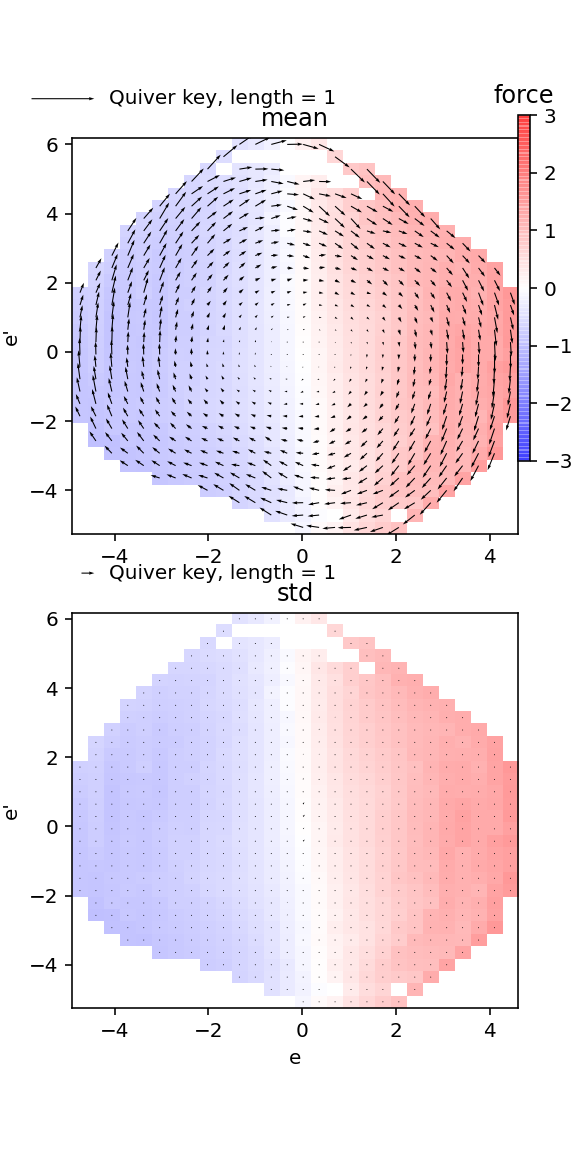

In [29]:
%matplotlib notebook
fig, ax = plt.subplots(2,1, figsize=(4,8))
# im_ax = ax[0].twinx()

im_extent = (vf_xbin_edges[0], vf_xbin_edges[-1], vf_ybin_edges[0], vf_ybin_edges[-1])
ax_im = ax[0].imshow(vf_f.T, extent=im_extent, origin='lower', cmap='bwr', vmin=-3, vmax=3, alpha=0.5, aspect='auto')
# ax[0].get_xaxis().set_visible(False)
# ax[0].get_yaxis().set_visible(False)
ax[1].imshow(vf_f.T, extent=im_extent, origin='lower', cmap='bwr', vmin=-3, vmax=3, alpha=0.5, aspect='auto')
cax1 = fig.add_axes([0.9, 0.6, 0.02, 0.3])
cbar1 = fig.colorbar(ax_im, cax=cax1, orientation='vertical')
cax1.set_title('force')
# ax[1].imshow(vf_eff, origin='lower', cmap='Reds', alpha=0.8)

colr1 = np.arctan2(dirxy_mean[:,0], dirxy_mean[:,1])
ax_q1 = ax[0].quiver(locxy_mean[:,0], locxy_mean[:,1], dirxy_mean[:,0], dirxy_mean[:,1], color='k')#colr1, cmap='hsv')
ax[0].quiverkey(ax_q1, X=0.05, Y=1.1, U=1,
             label='Quiver key, length = 1', labelpos='E')


colr2 = np.sqrt(dirxy_std[:,0]**2 + dirxy_std[:,1]**2)
ax_q2 = ax[1].quiver(locxy_mean[:,0], locxy_mean[:,1], dirxy_std[:,0], dirxy_std[:,1], 
                     color='k',
                    scale=34.8)
ax[1].quiverkey(ax_q2, X=0.05, Y=1.1, U=1,
             label='Quiver key, length = 1', labelpos='E')
# cax2 = fig.add_axes([0.9, 0.1, 0.02, 0.3])
# cbar2 = fig.colorbar(ax_q2, cax=cax2, orientation='vertical')

ax[0].set_title('mean')
ax[1].set_title('std')
ax[0].set_ylabel('e\'')
ax[1].set_ylabel('e\'')
ax[1].set_xlabel('e')

fig.savefig('tmp_vecfield1.png', dpi=300)

<IPython.core.display.Javascript object>


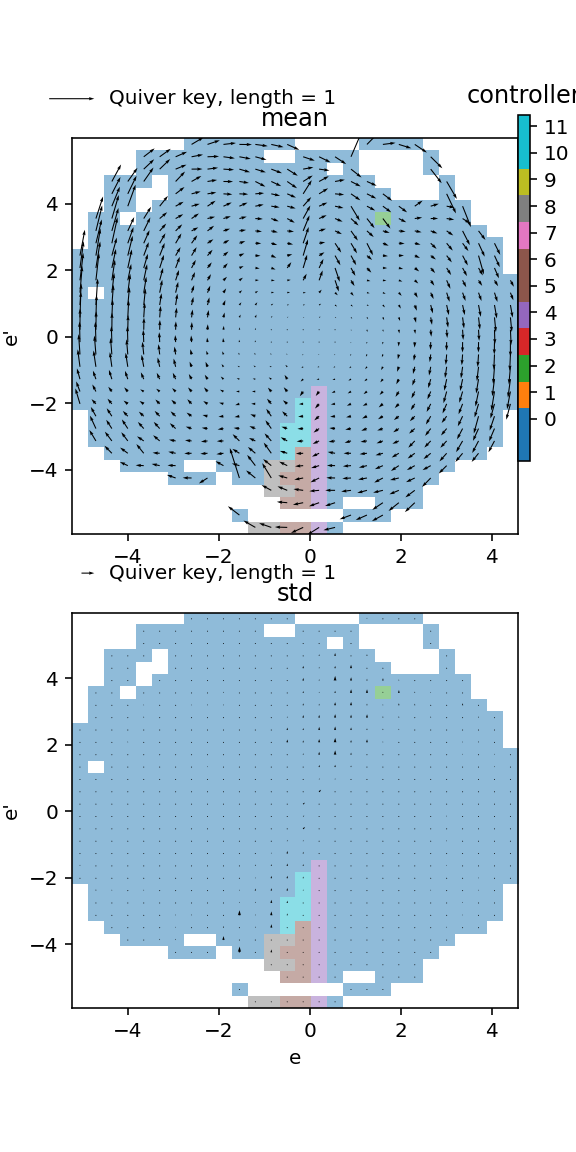

In [42]:
vf_bg = vf_cont
vf_bg_name = 'controller'
# n_clusters = len(np.unique(vf_cont))
bg_cmap = cl_cmap #plt.get_cmap('tab10', n_clusters)

%matplotlib notebook
fig, ax = plt.subplots(2,1, figsize=(4,8))
# im_ax = ax[0].twinx()

im_extent = (vf_xbin_edges[0], vf_xbin_edges[-1], vf_ybin_edges[0], vf_ybin_edges[-1])
ax_im = ax[0].imshow(vf_bg.T, extent=im_extent, origin='lower', cmap=bg_cmap, alpha=0.5, aspect='auto')
# ax[0].get_xaxis().set_visible(False)
# ax[0].get_yaxis().set_visible(False)
ax[1].imshow(vf_bg.T, extent=im_extent, origin='lower', cmap=bg_cmap, alpha=0.5, aspect='auto')

cax1 = fig.add_axes([0.9, 0.6, 0.02, 0.3])
cbar1 = fig.colorbar(ax_scat, cax=cax1, orientation='vertical')
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cbar1.set_ticks(tick_locs)
cbar1.set_ticklabels(np.arange(n_clusters))
cax1.set_title(vf_bg_name)


colr1 = np.arctan2(dirxy_mean[:,0], dirxy_mean[:,1])
ax_q1 = ax[0].quiver(locxy_mean[:,0], locxy_mean[:,1], dirxy_mean[:,0], dirxy_mean[:,1], color='k')#colr1, cmap='hsv')
ax[0].quiverkey(ax_q1, X=0.05, Y=1.1, U=1,
             label='Quiver key, length = 1', labelpos='E')


colr2 = np.sqrt(dirxy_std[:,0]**2 + dirxy_std[:,1]**2)
ax_q2 = ax[1].quiver(locxy_mean[:,0], locxy_mean[:,1], dirxy_std[:,0], dirxy_std[:,1], 
                     color='k',
                    scale=34.8)
ax[1].quiverkey(ax_q2, X=0.05, Y=1.1, U=1,
             label='Quiver key, length = 1', labelpos='E')
# cax2 = fig.add_axes([0.9, 0.1, 0.02, 0.3])
# cbar2 = fig.colorbar(ax_q2, cax=cax2, orientation='vertical')

ax[0].set_title('mean')
ax[1].set_title('std')
ax[0].set_ylabel('e\'')
ax[1].set_ylabel('e\'')
ax[1].set_xlabel('e')

fig.savefig('tmp_vecfield1.png', dpi=300)

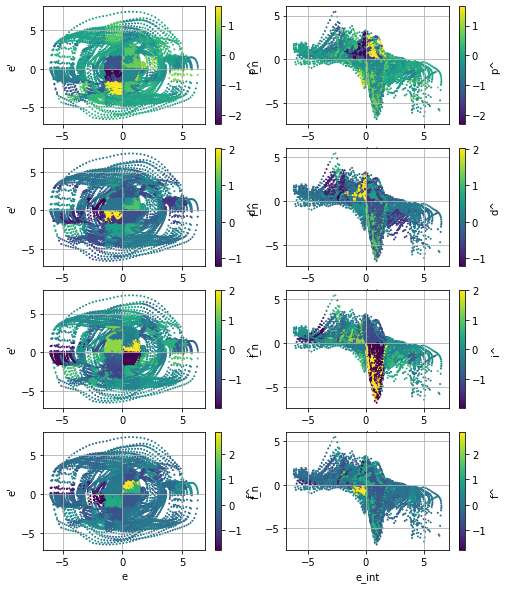

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1,2,figsize=(8,4))
# df1.plot.scatter(x='e', y='f_own', s=1, c='p^', colormap='viridis', ax=ax[0]);
# df1.plot.scatter(x='e', y='e\'', s=1, c='p^', colormap='viridis', ax=ax[1]);

fig, ax = plt.subplots(4,2,figsize=(8,10))
df1.plot.scatter(x='e_int', y='f_n', s=1, c='p^', colormap='viridis', ax=ax[0,1]);
df1.plot.scatter(x='e', y='e\'', s=1, c='p^', colormap='viridis', ax=ax[0,0]);

df1.plot.scatter(x='e_int', y='f_n', s=1, c='d^', colormap='viridis', ax=ax[1,1]);
df1.plot.scatter(x='e', y='e\'', s=1, c='d^', colormap='viridis', ax=ax[1,0]);

df1.plot.scatter(x='e_int', y='f_n', s=1, c='i^', colormap='viridis', ax=ax[2,1]);
df1.plot.scatter(x='e', y='e\'', s=1, c='i^', colormap='viridis', ax=ax[2,0]);

df1.plot.scatter(x='e_int', y='f_n', s=1, c='f^', colormap='viridis', ax=ax[3,1]);
df1.plot.scatter(x='e', y='e\'', s=1, c='f^', colormap='viridis', ax=ax[3,0]);

for i, axij in np.ndenumerate(ax):
    axij.grid(b=True, which='both')

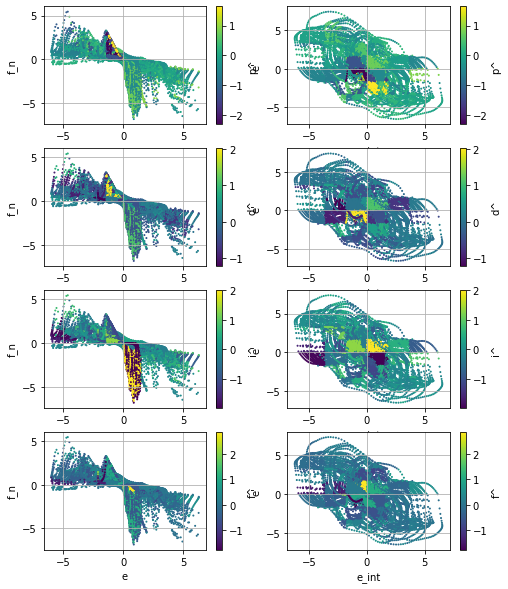

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1,2,figsize=(8,4))
# df1.plot.scatter(x='e', y='f_own', s=1, c='p^', colormap='viridis', ax=ax[0]);
# df1.plot.scatter(x='e', y='e\'', s=1, c='p^', colormap='viridis', ax=ax[1]);

fig, ax = plt.subplots(4,2,figsize=(8,10))
df1.plot.scatter(x='e_int', y='e\'', s=1, c='p^', colormap='viridis', ax=ax[0,1]);
df1.plot.scatter(x='e', y='f_n', s=1, c='p^', colormap='viridis', ax=ax[0,0]);

df1.plot.scatter(x='e_int', y='e\'', s=1, c='d^', colormap='viridis', ax=ax[1,1]);
df1.plot.scatter(x='e', y='f_n', s=1, c='d^', colormap='viridis', ax=ax[1,0]);

df1.plot.scatter(x='e_int', y='e\'', s=1, c='i^', colormap='viridis', ax=ax[2,1]);
df1.plot.scatter(x='e', y='f_n', s=1, c='i^', colormap='viridis', ax=ax[2,0]);

df1.plot.scatter(x='e_int', y='e\'', s=1, c='f^', colormap='viridis', ax=ax[3,1]);
df1.plot.scatter(x='e', y='f_n', s=1, c='f^', colormap='viridis', ax=ax[3,0]);

for i, axij in np.ndenumerate(ax):
    axij.grid(b=True, which='both')

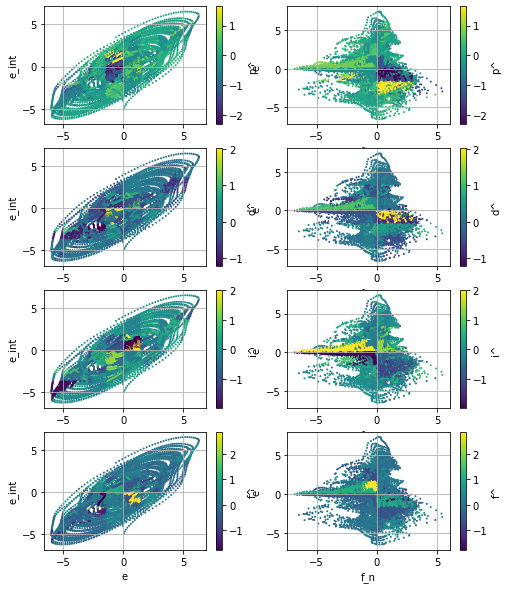

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1,2,figsize=(8,4))
# df1.plot.scatter(x='e', y='f_own', s=1, c='p^', colormap='viridis', ax=ax[0]);
# df1.plot.scatter(x='e', y='e\'', s=1, c='p^', colormap='viridis', ax=ax[1]);

fig, ax = plt.subplots(4,2,figsize=(8,10))
df1.plot.scatter(x='f_n', y='e\'', s=1, c='p^', colormap='viridis', ax=ax[0,1]);
df1.plot.scatter(x='e', y='e_int', s=1, c='p^', colormap='viridis', ax=ax[0,0]);

df1.plot.scatter(x='f_n', y='e\'', s=1, c='d^', colormap='viridis', ax=ax[1,1]);
df1.plot.scatter(x='e', y='e_int', s=1, c='d^', colormap='viridis', ax=ax[1,0]);

df1.plot.scatter(x='f_n', y='e\'', s=1, c='i^', colormap='viridis', ax=ax[2,1]);
df1.plot.scatter(x='e', y='e_int', s=1, c='i^', colormap='viridis', ax=ax[2,0]);

df1.plot.scatter(x='f_n', y='e\'', s=1, c='f^', colormap='viridis', ax=ax[3,1]);
df1.plot.scatter(x='e', y='e_int', s=1, c='f^', colormap='viridis', ax=ax[3,0]);

for i, axij in np.ndenumerate(ax):
    axij.grid(b=True, which='both')

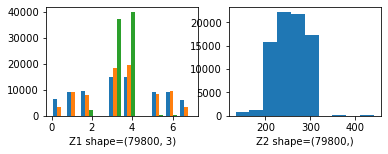

In [23]:
n_plots = len(xhiddens)
fig, ax = plt.subplots(1,n_plots, figsize=(6,2))
for i in range(n_plots):
    ax[i].hist(xhiddens[i])
    ax[i].set_xlabel('Z'+str(i+1)+' shape='+str(xhiddens[i].shape))

TypeError: Invalid shape () for image data

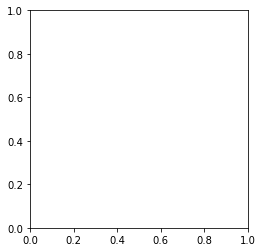

In [24]:
# Check the correlation between the hidden variables in fc2
xtt = np.corrcoef(xhiddens[1].T)
plt.imshow(xtt)
plt.title('The correlation between the hidden variables')
plt.colorbar()

In [25]:
# alldata = np.concatenate((xfeatures_n,
#                           np.log(xactions),
#                           xhiddens[1],
#                           xforces.reshape(-1,1)), axis=1)
# df1 = pd.DataFrame(alldata, columns=ftr_names+act_names+hid_names+['f_new'])
# df1 = df1.astype(float)

# plt.figure(figsize=(12,10))
# cor1 = df1.corr()
# sns.heatmap(cor1, annot=True, cmap=plt.cm.Reds)
# plt.show()

array([[<AxesSubplot:title={'center':'p^'}>]], dtype=object)

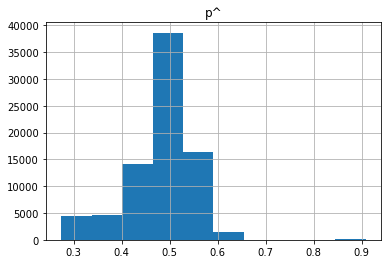

In [27]:
# _ = plt.hist(xactions)
df1.hist('p^')

In [28]:
# alldata2 = np.concatenate((abs(xfeatures_n),
#                           xactions,
#                           xhiddens[1],
#                           abs(xforces).reshape(-1,1)), axis=1)
# df2 = pd.DataFrame(alldata2, columns=ftr_names+act_names+hid_names+['f_new'])

# df2 = df2.astype(float)

# plt.figure(figsize=(12,10))
# cor2 = df2.corr()
# sns.heatmap(cor2, annot=True, cmap=plt.cm.Reds)
# plt.title('Correlations; (The absolute value of the features is used)')
# plt.show()

In [29]:
# features = xfeatures#_n

In [30]:
# # offsets = get_neighborhood_offsets(n_ftr=9, radius=0.05)
# offsets_ = get_neighborhood_offsets(n_ftr=3, radius=0.2)
# offsets = [[0.]*3+e_offs+[0.]*3 for e_offs in offsets_]
# offsets = scaler.inverse_transform(offsets)

# regrs_a = np.zeros((features.shape[0], 4))#features.shape[1]+1))
# regrs_h = np.zeros((features.shape[0], features.shape[1]+1))
# for i in range(features.shape[0]):
#     if i%1000==0:
#         print('i = ',i)
#     regrs_a[i,:], regrs_h[i,:] = get_regressor(features[i,:], offsets)

In [31]:
# regrs = regrs_a
# n_comps = 2
# pca_neighs = PCA(n_components=n_comps)
# pca_neighs.fit(regrs)
# print(pca_neighs.explained_variance_ratio_)
# print(pca_neighs.singular_values_)

In [32]:
# print("Mean of the regressors: ", list2str(regrs.mean(axis=0)))
# display(Markdown('**Principal vectors of the regressors**'))
# comp_strs = []
# for i in range(n_comps):
#     print("Component ", i, " with SV= ", "{0:0.0f}".format(pca_neighs.singular_values_[i]), ": ")
#     comp_strs.append("%.2f  $e + $ %.2f  $e\' + $ %.2f  $e\" + $ %.2f"%
#                   (pca_neighs.components_[i,0], 
#                   pca_neighs.components_[i,1],
#                   pca_neighs.components_[i,2],
#                   pca_neighs.components_[i,3]))
#     display(Latex(comp_strs[i])
#            )

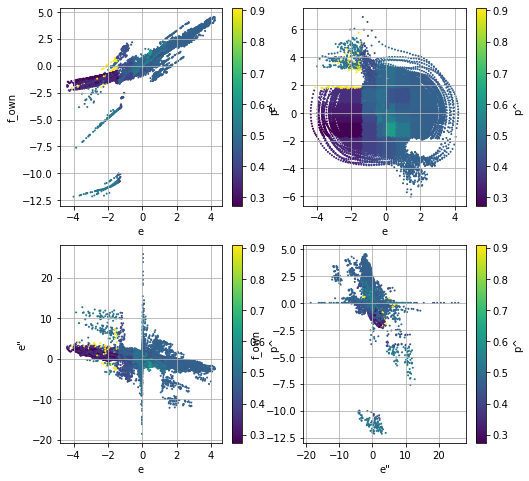

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1,2,figsize=(8,4))
# df1.plot.scatter(x='e', y='f_own', s=1, c='p^', colormap='viridis', ax=ax[0]);
# df1.plot.scatter(x='e', y='e\'', s=1, c='p^', colormap='viridis', ax=ax[1]);

fig, ax = plt.subplots(2,2,figsize=(8,8))
df1.plot.scatter(x='e', y='f_own', s=1, c='p^', colormap='viridis', ax=ax[0,0]);
# df1.plot.scatter(x='r\'', y='f_own', s=1, c='p^', colormap='viridis', ax=ax[0,0]);
df1.plot.scatter(x='e', y='e\'', s=1, c='p^', colormap='viridis', ax=ax[0,1]);
df1.plot.scatter(x='e', y='e\"', s=1, c='p^', colormap='viridis', ax=ax[1,0]);
df1.plot.scatter(x='e\"', y='f_own', s=1, c='p^', colormap='viridis', ax=ax[1,1]);

for i, axij in np.ndenumerate(ax):
    axij.grid(b=True, which='both')

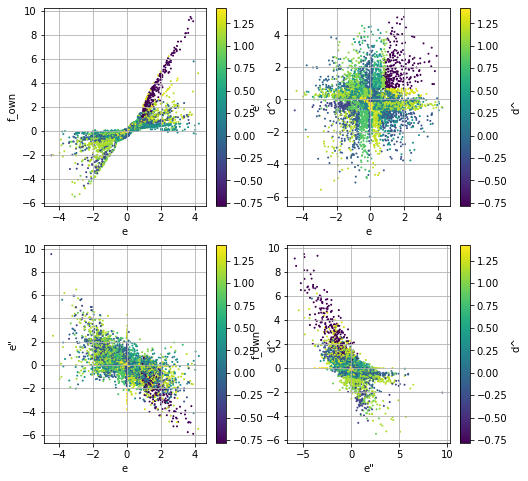

In [24]:
# fig, ax = plt.subplots(1,2,figsize=(8,4))
# df1.plot.scatter(x='e', y='f_own', s=1, c='p^', colormap='viridis', ax=ax[0]);
# df1.plot.scatter(x='e', y='e\'', s=1, c='p^', colormap='viridis', ax=ax[1]);

fig, ax = plt.subplots(2,2,figsize=(8,8))
df1.plot.scatter(x='e', y='f_own', s=1, c='d^', colormap='viridis', ax=ax[0,0]);
df1.plot.scatter(x='e', y='e\'', s=1, c='d^', colormap='viridis', ax=ax[0,1]);
# df1.plot.scatter(x='e\'', y='e\"', s=1, c='d^', colormap='viridis', ax=ax[0,1]);
df1.plot.scatter(x='e', y='e\"', s=1, c='d^', colormap='viridis', ax=ax[1,0]);
df1.plot.scatter(x='e\"', y='f_own', s=1, c='d^', colormap='viridis', ax=ax[1,1]);

for i, axij in np.ndenumerate(ax):
    axij.grid(b=True, which='both')

In [25]:
def plot_df_vars(df, xvar, yvar, zvar, cvar, figsize=(5,5), **kwargs):
    
    %matplotlib notebook
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax_scat = ax.scatter(df[xvar], df[yvar], df[zvar], s=1, c=df[cvar], **kwargs)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)
    ax.set_zlabel(zvar)

    cax = fig.add_axes([0.05, 0.3, 0.02, 0.5])
    cbar = fig.colorbar(ax_scat, cax=cax, orientation='vertical')
    cbar.set_label(cvar)

<IPython.core.display.Javascript object>


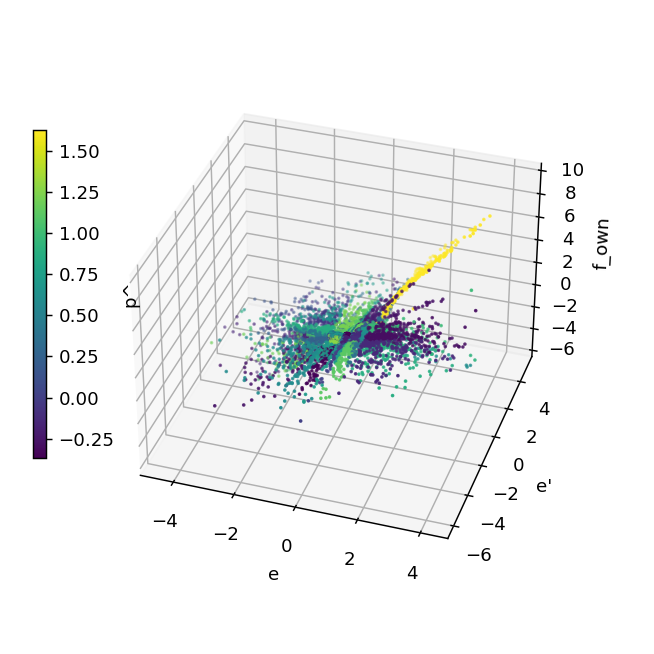

In [26]:
# plt_vars = ['e', 'e\'', 'f_own', 'p^', 'd^', 'f^']
cvar = 'p^'
plot_df_vars(df1, 'e', 'e\'', 'f_own', cvar)

<IPython.core.display.Javascript object>


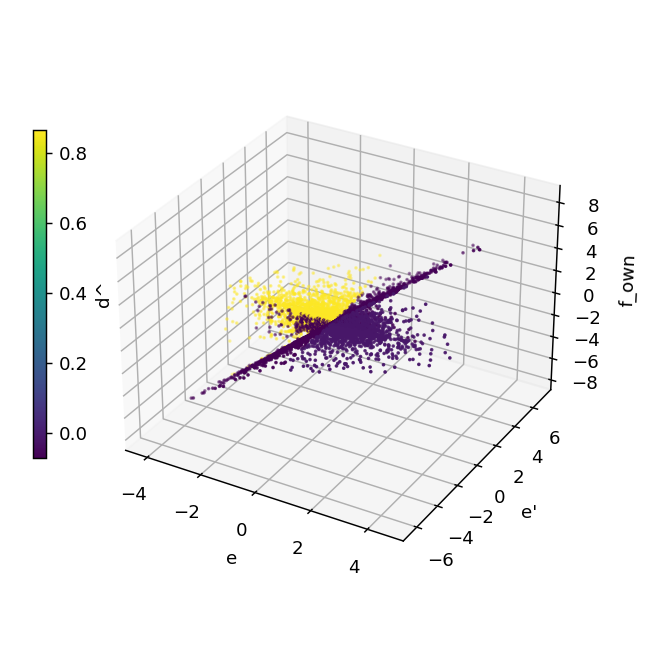

In [39]:
# plt_vars = ['e', 'e\'', 'f_own', 'p^', 'd^', 'f^']
cvar = 'd^'
plot_df_vars(df1, 'e', 'e\'', 'f_own', cvar)